In [1]:
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os
from scipy.stats import chi2, norm

# DM parameters are fixed throughout this analysis
from dm_params import sv, fx
from utilities import e_low_excess, e_high_excess
from background_models import phi_g_egb_fermi, phi_e_bg_dampe
from finite_clump_vectorized import rho_s_dampe, luminosity, phi_g, phi_e, rho
from finite_clump_vectorized import gamma_ray_extent, line_width_constraint, mass
from finite_clump_vectorized import fermi_point_src_contraint, anisotropy_differential
from finite_clump_vectorized import anisotropy_integrated, line_width_constraint_chi2
from utilities import e_high_excess, bins_dampe, i_excess
from utilities import fermi_psf, fermi_psf_solid_angle
from utilities import rho_max, dn_de_g_ap, fermi_pt_src_sens_0_0
from utilities import rho_earth, Hz_to_GeV2_cm3, GeV_to_m_sun, kpc_to_cm, t_universe
from utilities import e_low_aniso_fermi, e_high_aniso_fermi, aniso_fermi
from utilities import colors, mantissa_exp, sci_fmt, log_levels
from utilities import normal_contours, sci_contours

# Significance used for line width constraint
n_sigma = 3.
# Photon energy at which to compute fluxes
e_gamma_ref = 230.
# Flux above which Fermi should observe the clump as an extended source
# phi_g_fermi_ext = 1e-7  # (GeV cm^2 s sr)^2
# Directory with Ben's probability data files
pr_base_path = "../DAMPE+DM clumps/data/likelihoods/"

In [2]:
# # Reference chi^2 value for very small, nearby clump
# lw_chi2_ref = line_width_constraint_chi2(1e-4, 1e-4, rho_s_dampe(1e-4, 1e-4, 1.0, "nfw"), 1.0, "nfw")

# # Critical value for 95% CL bounds on d and r_s
# chi2_crit = chi2(2).ppf(0.95)

# Varying $m_\chi$

In [28]:
halo = "nfw"
d, rs, gamma = 0.5, 0.5, 0.5

In [ ]:
range(i_excess - 1) + range(i_excess + 2, len(bins_dampe))

In [22]:
from scipy.optimize import minimize_scalar

excl_idxs = range(i_excess - 1) + range(i_excess + 2, len(bins_dampe))

def fit_mx(d, rs, gamma, halo, stat="chi2", excluded_idxs=[]):
    def helper(d, rs):
        if d < 0.1 and rs < 1:
            mx = e_high_excess
        else:
            def objective(mx):
                rhos = rho_s_dampe(d, rs, gamma, halo, mx)
                if stat == "chi2":
                    return line_width_constraint_chi2(d, rs, rhos, gamma, halo, mx,
                                                      excluded_idxs=excluded_idxs)
                elif stat == "z":
                    return line_width_constraint(d, rs, rhos, gamma, halo, mx, n_sigma=1e10,
                                                 excluded_idxs=excluded_idxs)
                else:
                    raise ValueError("invalid 'stat'")

            fit = minimize_scalar(objective, bounds=[e_high_excess, bins_dampe[i_excess + 1][1]],
                                  method="bounded")
            mx = fit.x

        print("fit (d, rs) = ({}, {})".format(d, rs))
        return mx
    
    return np.vectorize(helper)(d, rs)

### Scratch

In [64]:
gamma = 0.52
halo = "exp"

dist = np.logspace(-3, 0, 6)
r_s = np.logspace(-3, 1, 3)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

In [65]:
mx_mg = fit_mx(dist_mg, r_s_mg, gamma, halo)

In [66]:
os.system("say 'done'")

0

Text(0.5,1,'exp, gamma = 0.52')

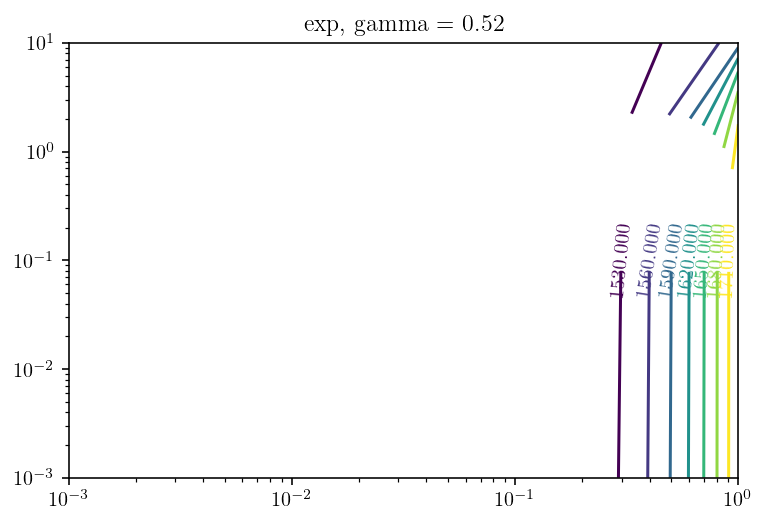

In [67]:
cs = plt.contour(dist_mg, r_s_mg, mx_mg)
plt.xscale("log")
plt.yscale("log")
plt.clabel(cs, inline=True)
plt.title("{}, gamma = {}".format(halo, gamma))

Text(0.5,1,'exp, gamma = 1.08')

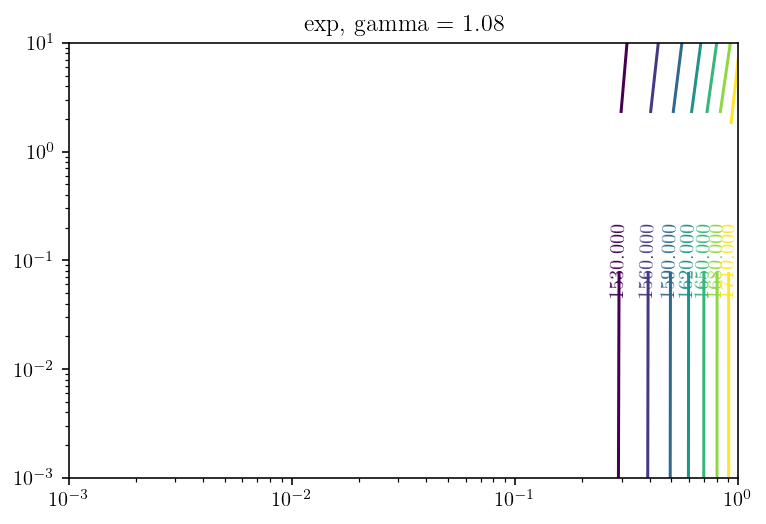

In [59]:
# plt.contourf(dist_mg, r_s_mg, lw_nfw, levels=[3, 1e10])
cs = plt.contour(dist_mg, r_s_mg, mx_mg)
plt.xscale("log")
plt.yscale("log")
plt.clabel(cs, inline=True)
plt.title("{}, gamma = {}".format(halo, gamma))

<a list of 7 text.Text objects>

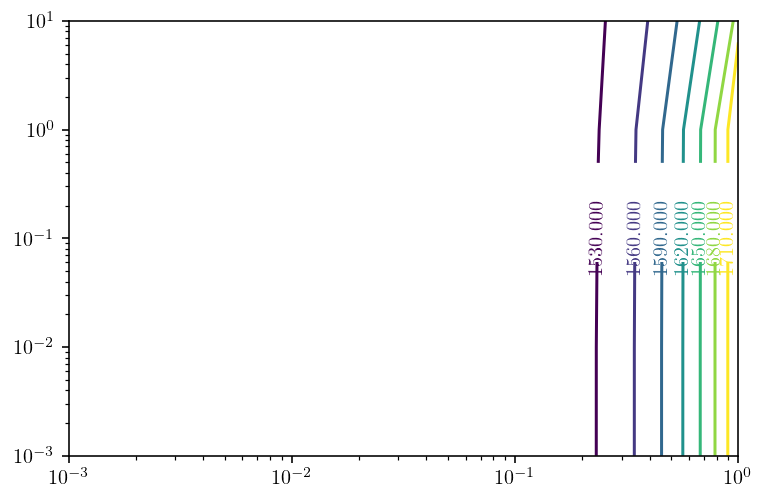

In [41]:
# plt.contourf(dist_mg, r_s_mg, lw_nfw, levels=[3, 1e10])
cs = plt.contour(dist_mg, r_s_mg, mx_mg)
plt.xscale("log")
plt.yscale("log")
plt.clabel(cs, inline=True)

In [68]:
rho_s_mg = np.vectorize(rho_s_dampe)(dist_mg, r_s_mg, gamma, halo, mx_mg)

In [69]:
lw_mg = np.vectorize(line_width_constraint)(dist_mg, r_s_mg, rho_s_mg, gamma, halo, mx_mg)

Text(0.5,1,'exp, gamma = 0.52')

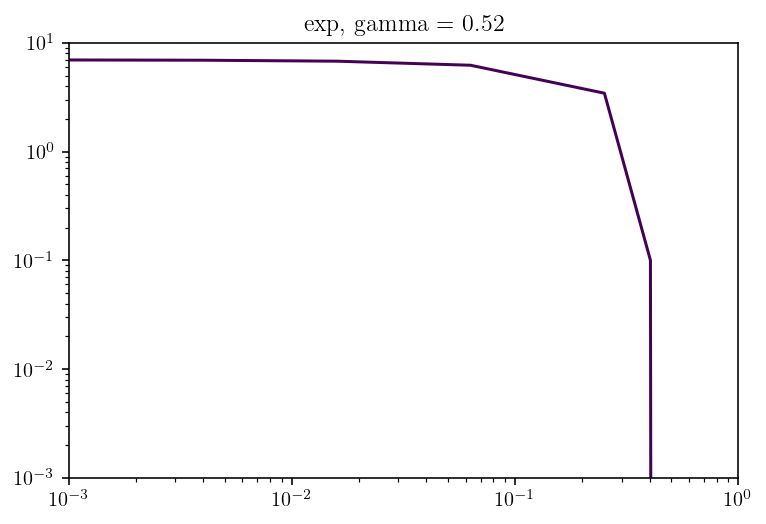

In [70]:
plt.contour(dist_mg, r_s_mg, lw_mg, levels=[0, 3, 1e5])
plt.xscale("log")
plt.yscale("log")
plt.title("{}, gamma = {}".format(halo, gamma))

Text(0.5,1,'exp, gamma = 1.08')

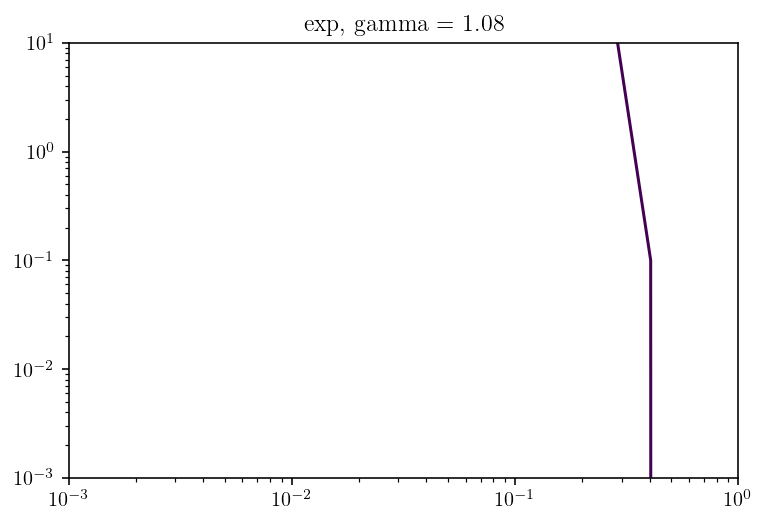

In [62]:
plt.contour(dist_mg, r_s_mg, lw_mg, levels=[0, 3, 1e5])
plt.xscale("log")
plt.yscale("log")
plt.title("{}, gamma = {}".format(halo, gamma))

Text(0.5,1,'nfw, gamma = 0.5')

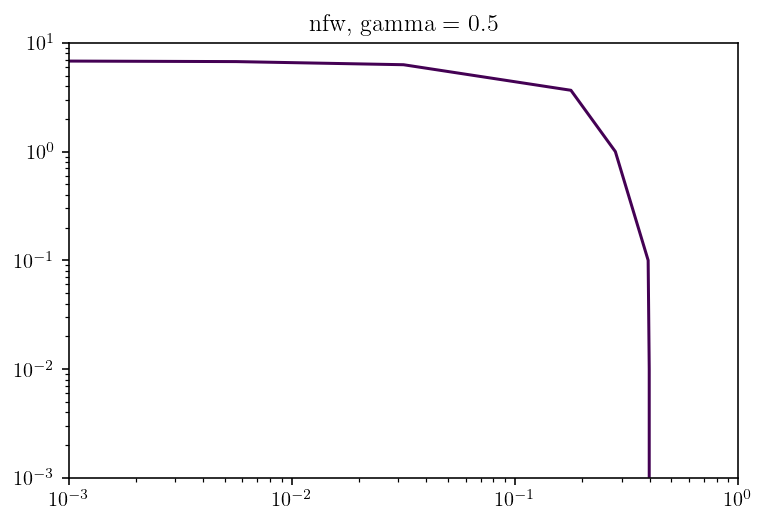

In [55]:
plt.contour(dist_mg, r_s_mg, lw_mg, levels=[0, 3, 1e5])
plt.xscale("log")
plt.yscale("log")
plt.title("{}, gamma = {}".format(halo, gamma))

In [30]:
mx = fit_mx(d, rs, gamma, halo)
rhos = rho_s_dampe(d, rs, gamma, halo, mx)

In [31]:
n_sigma = line_width_constraint(d, rs, rhos, gamma, halo, mx)
chi2 = line_width_constraint(d, rs, rhos, gamma, halo, mx)
print("n_sigma, chi2 = {}, {}".format(n_sigma, chi2))

n_sigma, chi2 = 3.48320023794, 3.48320023794


In [32]:
es = np.linspace(800, 1700, 500)
phis = 2 * phi_e(es, d, rs, rhos, gamma, "nfw", mx) + phi_e_bg_dampe(es)

(5e-13, 5e-11)

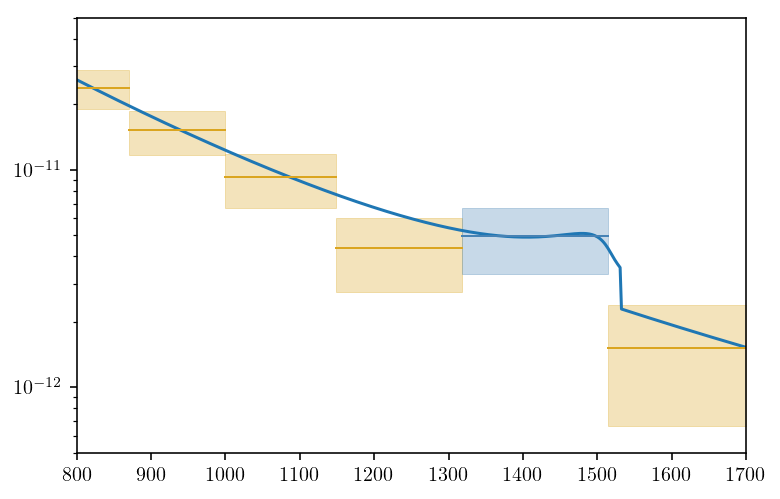

In [33]:
from utilities import plot_obs

plt.plot(es, phis)
plot_obs(0, plt.gca(), n_sigma=3)
plt.yscale("log")
plt.xlim(800, 1700)
plt.ylim(5e-13, 5e-11)

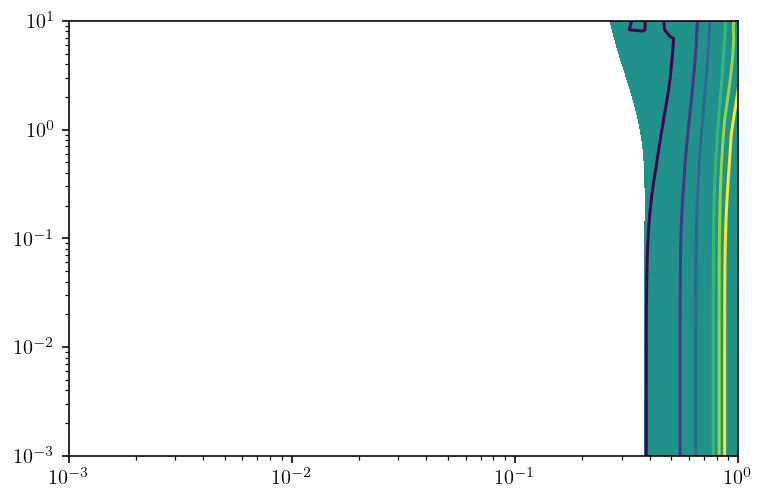

In [33]:
plt.contourf(dist_mg, r_s_mg, lw_nfw, levels=[3, 1e10])
plt.contour(dist_mg, r_s_mg, mxs[1])
plt.xscale("log")
plt.yscale("log")

# NFW profile

In [2]:
gamma_nfw = 0.5
# gamma_nfw = 1.

dist = np.logspace(-3, 0, 50)
r_s = np.logspace(-3, 1, 50)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

base_path_nfw = 'data/fixed_mx/nfw_gamma_%.1f/' % gamma_nfw

## Load results

In [3]:
for var in ["dist", "r_s"]:
    exec(var + " = np.loadtxt('" + base_path_nfw + var + ".csv', delimiter=',')")
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

for var in ["rho_s", "rho_rel", "lum", "phi_g", "lw", "rho_s_fermi_ps_0_0",
            "rho_s_fermi_ps", "phi_g_ext_rel", "extent", "masses"]:
    exec(var + "_nfw = np.loadtxt('" + base_path_nfw + var + ".csv', delimiter=',')")

# Load likelihoods using Ben's processing
dist_pr, r_s_pr, pr_nfw = np.genfromtxt(
    pr_base_path + "nfw/sigmas_nfw_gamma_%.2f.csv" % gamma_nfw,
    delimiter=',').T

dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1).T
r_s_pr = r_s_pr.reshape(dist_pr.shape).T
pr_nfw = pr_nfw.reshape(dist_pr.shape).T

## Recompute

### DM mass

In [23]:
mx_nfw = fit_mx(dist_mg, r_s_mg, gamma_nfw, "nfw", "z", excl_idxs)

fit (d, rs) = (0.001, 0.001)
fit (d, rs) = (0.001, 0.001)
fit (d, rs) = (0.00115139539933, 0.001)
fit (d, rs) = (0.00132571136559, 0.001)
fit (d, rs) = (0.00152641796718, 0.001)
fit (d, rs) = (0.00175751062485, 0.001)
fit (d, rs) = (0.00202358964773, 0.001)
fit (d, rs) = (0.00232995181052, 0.001)
fit (d, rs) = (0.00268269579528, 0.001)
fit (d, rs) = (0.00308884359648, 0.001)
fit (d, rs) = (0.00355648030622, 0.001)
fit (d, rs) = (0.00409491506238, 0.001)
fit (d, rs) = (0.00471486636346, 0.001)
fit (d, rs) = (0.00542867543932, 0.001)
fit (d, rs) = (0.00625055192527, 0.001)
fit (d, rs) = (0.00719685673001, 0.001)
fit (d, rs) = (0.00828642772855, 0.001)
fit (d, rs) = (0.0095409547635, 0.001)
fit (d, rs) = (0.0109854114199, 0.001)
fit (d, rs) = (0.0126485521686, 0.001)
fit (d, rs) = (0.014563484775, 0.001)
fit (d, rs) = (0.0167683293681, 0.001)
fit (d, rs) = (0.0193069772888, 0.001)
fit (d, rs) = (0.0222299648253, 0.001)
fit (d, rs) = (0.025595479227, 0.001)
fit (d, rs) = (0.0294705170255, 

fit (d, rs) = (0.104811313415, 0.00175751062485)
fit (d, rs) = (0.120679264064, 0.00175751062485)
fit (d, rs) = (0.138949549437, 0.00175751062485)
fit (d, rs) = (0.159985871961, 0.00175751062485)
fit (d, rs) = (0.184206996933, 0.00175751062485)
fit (d, rs) = (0.212095088792, 0.00175751062485)
fit (d, rs) = (0.244205309455, 0.00175751062485)
fit (d, rs) = (0.281176869797, 0.00175751062485)
fit (d, rs) = (0.323745754282, 0.00175751062485)
fit (d, rs) = (0.372759372031, 0.00175751062485)
fit (d, rs) = (0.429193426013, 0.00175751062485)
fit (d, rs) = (0.494171336132, 0.00175751062485)
fit (d, rs) = (0.568986602902, 0.00175751062485)
fit (d, rs) = (0.65512855686, 0.00175751062485)
fit (d, rs) = (0.754312006335, 0.00175751062485)
fit (d, rs) = (0.868511373751, 0.00175751062485)
fit (d, rs) = (1.0, 0.00175751062485)
fit (d, rs) = (0.001, 0.00212095088792)
fit (d, rs) = (0.00115139539933, 0.00212095088792)
fit (d, rs) = (0.00132571136559, 0.00212095088792)
fit (d, rs) = (0.00152641796718, 0.00

fit (d, rs) = (0.104811313415, 0.00372759372031)
fit (d, rs) = (0.120679264064, 0.00372759372031)
fit (d, rs) = (0.138949549437, 0.00372759372031)
fit (d, rs) = (0.159985871961, 0.00372759372031)
fit (d, rs) = (0.184206996933, 0.00372759372031)
fit (d, rs) = (0.212095088792, 0.00372759372031)
fit (d, rs) = (0.244205309455, 0.00372759372031)
fit (d, rs) = (0.281176869797, 0.00372759372031)
fit (d, rs) = (0.323745754282, 0.00372759372031)
fit (d, rs) = (0.372759372031, 0.00372759372031)
fit (d, rs) = (0.429193426013, 0.00372759372031)
fit (d, rs) = (0.494171336132, 0.00372759372031)
fit (d, rs) = (0.568986602902, 0.00372759372031)
fit (d, rs) = (0.65512855686, 0.00372759372031)
fit (d, rs) = (0.754312006335, 0.00372759372031)
fit (d, rs) = (0.868511373751, 0.00372759372031)
fit (d, rs) = (1.0, 0.00372759372031)
fit (d, rs) = (0.001, 0.00449843266897)
fit (d, rs) = (0.00115139539933, 0.00449843266897)
fit (d, rs) = (0.00132571136559, 0.00449843266897)
fit (d, rs) = (0.00152641796718, 0.00

fit (d, rs) = (0.104811313415, 0.00790604321091)
fit (d, rs) = (0.120679264064, 0.00790604321091)
fit (d, rs) = (0.138949549437, 0.00790604321091)
fit (d, rs) = (0.159985871961, 0.00790604321091)
fit (d, rs) = (0.184206996933, 0.00790604321091)
fit (d, rs) = (0.212095088792, 0.00790604321091)
fit (d, rs) = (0.244205309455, 0.00790604321091)
fit (d, rs) = (0.281176869797, 0.00790604321091)
fit (d, rs) = (0.323745754282, 0.00790604321091)
fit (d, rs) = (0.372759372031, 0.00790604321091)
fit (d, rs) = (0.429193426013, 0.00790604321091)
fit (d, rs) = (0.494171336132, 0.00790604321091)
fit (d, rs) = (0.568986602902, 0.00790604321091)
fit (d, rs) = (0.65512855686, 0.00790604321091)
fit (d, rs) = (0.754312006335, 0.00790604321091)
fit (d, rs) = (0.868511373751, 0.00790604321091)
fit (d, rs) = (1.0, 0.00790604321091)
fit (d, rs) = (0.001, 0.0095409547635)
fit (d, rs) = (0.00115139539933, 0.0095409547635)
fit (d, rs) = (0.00132571136559, 0.0095409547635)
fit (d, rs) = (0.00152641796718, 0.00954

fit (d, rs) = (0.104811313415, 0.0167683293681)
fit (d, rs) = (0.120679264064, 0.0167683293681)
fit (d, rs) = (0.138949549437, 0.0167683293681)
fit (d, rs) = (0.159985871961, 0.0167683293681)
fit (d, rs) = (0.184206996933, 0.0167683293681)
fit (d, rs) = (0.212095088792, 0.0167683293681)
fit (d, rs) = (0.244205309455, 0.0167683293681)
fit (d, rs) = (0.281176869797, 0.0167683293681)
fit (d, rs) = (0.323745754282, 0.0167683293681)
fit (d, rs) = (0.372759372031, 0.0167683293681)
fit (d, rs) = (0.429193426013, 0.0167683293681)
fit (d, rs) = (0.494171336132, 0.0167683293681)
fit (d, rs) = (0.568986602902, 0.0167683293681)
fit (d, rs) = (0.65512855686, 0.0167683293681)
fit (d, rs) = (0.754312006335, 0.0167683293681)
fit (d, rs) = (0.868511373751, 0.0167683293681)
fit (d, rs) = (1.0, 0.0167683293681)
fit (d, rs) = (0.001, 0.0202358964773)
fit (d, rs) = (0.00115139539933, 0.0202358964773)
fit (d, rs) = (0.00132571136559, 0.0202358964773)
fit (d, rs) = (0.00152641796718, 0.0202358964773)
fit (d,

fit (d, rs) = (0.104811313415, 0.0355648030622)
fit (d, rs) = (0.120679264064, 0.0355648030622)
fit (d, rs) = (0.138949549437, 0.0355648030622)
fit (d, rs) = (0.159985871961, 0.0355648030622)
fit (d, rs) = (0.184206996933, 0.0355648030622)
fit (d, rs) = (0.212095088792, 0.0355648030622)
fit (d, rs) = (0.244205309455, 0.0355648030622)
fit (d, rs) = (0.281176869797, 0.0355648030622)
fit (d, rs) = (0.323745754282, 0.0355648030622)
fit (d, rs) = (0.372759372031, 0.0355648030622)
fit (d, rs) = (0.429193426013, 0.0355648030622)
fit (d, rs) = (0.494171336132, 0.0355648030622)
fit (d, rs) = (0.568986602902, 0.0355648030622)
fit (d, rs) = (0.65512855686, 0.0355648030622)
fit (d, rs) = (0.754312006335, 0.0355648030622)
fit (d, rs) = (0.868511373751, 0.0355648030622)
fit (d, rs) = (1.0, 0.0355648030622)
fit (d, rs) = (0.001, 0.0429193426013)
fit (d, rs) = (0.00115139539933, 0.0429193426013)
fit (d, rs) = (0.00132571136559, 0.0429193426013)
fit (d, rs) = (0.00152641796718, 0.0429193426013)
fit (d,

fit (d, rs) = (0.104811313415, 0.0754312006335)
fit (d, rs) = (0.120679264064, 0.0754312006335)
fit (d, rs) = (0.138949549437, 0.0754312006335)
fit (d, rs) = (0.159985871961, 0.0754312006335)
fit (d, rs) = (0.184206996933, 0.0754312006335)
fit (d, rs) = (0.212095088792, 0.0754312006335)
fit (d, rs) = (0.244205309455, 0.0754312006335)
fit (d, rs) = (0.281176869797, 0.0754312006335)
fit (d, rs) = (0.323745754282, 0.0754312006335)
fit (d, rs) = (0.372759372031, 0.0754312006335)
fit (d, rs) = (0.429193426013, 0.0754312006335)
fit (d, rs) = (0.494171336132, 0.0754312006335)
fit (d, rs) = (0.568986602902, 0.0754312006335)
fit (d, rs) = (0.65512855686, 0.0754312006335)
fit (d, rs) = (0.754312006335, 0.0754312006335)
fit (d, rs) = (0.868511373751, 0.0754312006335)
fit (d, rs) = (1.0, 0.0754312006335)
fit (d, rs) = (0.001, 0.0910298177992)
fit (d, rs) = (0.00115139539933, 0.0910298177992)
fit (d, rs) = (0.00132571136559, 0.0910298177992)
fit (d, rs) = (0.00152641796718, 0.0910298177992)
fit (d,

fit (d, rs) = (0.104811313415, 0.159985871961)
fit (d, rs) = (0.120679264064, 0.159985871961)
fit (d, rs) = (0.138949549437, 0.159985871961)
fit (d, rs) = (0.159985871961, 0.159985871961)
fit (d, rs) = (0.184206996933, 0.159985871961)
fit (d, rs) = (0.212095088792, 0.159985871961)
fit (d, rs) = (0.244205309455, 0.159985871961)
fit (d, rs) = (0.281176869797, 0.159985871961)
fit (d, rs) = (0.323745754282, 0.159985871961)
fit (d, rs) = (0.372759372031, 0.159985871961)
fit (d, rs) = (0.429193426013, 0.159985871961)
fit (d, rs) = (0.494171336132, 0.159985871961)
fit (d, rs) = (0.568986602902, 0.159985871961)
fit (d, rs) = (0.65512855686, 0.159985871961)
fit (d, rs) = (0.754312006335, 0.159985871961)
fit (d, rs) = (0.868511373751, 0.159985871961)
fit (d, rs) = (1.0, 0.159985871961)
fit (d, rs) = (0.001, 0.193069772888)
fit (d, rs) = (0.00115139539933, 0.193069772888)
fit (d, rs) = (0.00132571136559, 0.193069772888)
fit (d, rs) = (0.00152641796718, 0.193069772888)
fit (d, rs) = (0.00175751062

fit (d, rs) = (0.104811313415, 0.33932217719)
fit (d, rs) = (0.120679264064, 0.33932217719)
fit (d, rs) = (0.138949549437, 0.33932217719)
fit (d, rs) = (0.159985871961, 0.33932217719)
fit (d, rs) = (0.184206996933, 0.33932217719)
fit (d, rs) = (0.212095088792, 0.33932217719)
fit (d, rs) = (0.244205309455, 0.33932217719)
fit (d, rs) = (0.281176869797, 0.33932217719)
fit (d, rs) = (0.323745754282, 0.33932217719)
fit (d, rs) = (0.372759372031, 0.33932217719)
fit (d, rs) = (0.429193426013, 0.33932217719)
fit (d, rs) = (0.494171336132, 0.33932217719)
fit (d, rs) = (0.568986602902, 0.33932217719)
fit (d, rs) = (0.65512855686, 0.33932217719)
fit (d, rs) = (0.754312006335, 0.33932217719)
fit (d, rs) = (0.868511373751, 0.33932217719)
fit (d, rs) = (1.0, 0.33932217719)
fit (d, rs) = (0.001, 0.409491506238)
fit (d, rs) = (0.00115139539933, 0.409491506238)
fit (d, rs) = (0.00132571136559, 0.409491506238)
fit (d, rs) = (0.00152641796718, 0.409491506238)
fit (d, rs) = (0.00175751062485, 0.4094915062

fit (d, rs) = (0.104811313415, 0.719685673001)
fit (d, rs) = (0.120679264064, 0.719685673001)
fit (d, rs) = (0.138949549437, 0.719685673001)
fit (d, rs) = (0.159985871961, 0.719685673001)
fit (d, rs) = (0.184206996933, 0.719685673001)
fit (d, rs) = (0.212095088792, 0.719685673001)
fit (d, rs) = (0.244205309455, 0.719685673001)
fit (d, rs) = (0.281176869797, 0.719685673001)
fit (d, rs) = (0.323745754282, 0.719685673001)
fit (d, rs) = (0.372759372031, 0.719685673001)
fit (d, rs) = (0.429193426013, 0.719685673001)
fit (d, rs) = (0.494171336132, 0.719685673001)
fit (d, rs) = (0.568986602902, 0.719685673001)
fit (d, rs) = (0.65512855686, 0.719685673001)
fit (d, rs) = (0.754312006335, 0.719685673001)
fit (d, rs) = (0.868511373751, 0.719685673001)
fit (d, rs) = (1.0, 0.719685673001)
fit (d, rs) = (0.001, 0.868511373751)
fit (d, rs) = (0.00115139539933, 0.868511373751)
fit (d, rs) = (0.00132571136559, 0.868511373751)
fit (d, rs) = (0.00152641796718, 0.868511373751)
fit (d, rs) = (0.00175751062

fit (d, rs) = (0.00355648030622, 1.52641796718)
fit (d, rs) = (0.00409491506238, 1.52641796718)
fit (d, rs) = (0.00471486636346, 1.52641796718)
fit (d, rs) = (0.00542867543932, 1.52641796718)
fit (d, rs) = (0.00625055192527, 1.52641796718)
fit (d, rs) = (0.00719685673001, 1.52641796718)
fit (d, rs) = (0.00828642772855, 1.52641796718)
fit (d, rs) = (0.0095409547635, 1.52641796718)
fit (d, rs) = (0.0109854114199, 1.52641796718)
fit (d, rs) = (0.0126485521686, 1.52641796718)
fit (d, rs) = (0.014563484775, 1.52641796718)
fit (d, rs) = (0.0167683293681, 1.52641796718)
fit (d, rs) = (0.0193069772888, 1.52641796718)
fit (d, rs) = (0.0222299648253, 1.52641796718)
fit (d, rs) = (0.025595479227, 1.52641796718)
fit (d, rs) = (0.0294705170255, 1.52641796718)
fit (d, rs) = (0.033932217719, 1.52641796718)
fit (d, rs) = (0.0390693993705, 1.52641796718)
fit (d, rs) = (0.0449843266897, 1.52641796718)
fit (d, rs) = (0.0517947467923, 1.52641796718)
fit (d, rs) = (0.0596362331659, 1.52641796718)
fit (d, r

fit (d, rs) = (0.138949549437, 2.68269579528)
fit (d, rs) = (0.159985871961, 2.68269579528)
fit (d, rs) = (0.184206996933, 2.68269579528)
fit (d, rs) = (0.212095088792, 2.68269579528)
fit (d, rs) = (0.244205309455, 2.68269579528)
fit (d, rs) = (0.281176869797, 2.68269579528)
fit (d, rs) = (0.323745754282, 2.68269579528)
fit (d, rs) = (0.372759372031, 2.68269579528)
fit (d, rs) = (0.429193426013, 2.68269579528)
fit (d, rs) = (0.494171336132, 2.68269579528)
fit (d, rs) = (0.568986602902, 2.68269579528)
fit (d, rs) = (0.65512855686, 2.68269579528)
fit (d, rs) = (0.754312006335, 2.68269579528)
fit (d, rs) = (0.868511373751, 2.68269579528)
fit (d, rs) = (1.0, 2.68269579528)
fit (d, rs) = (0.001, 3.23745754282)
fit (d, rs) = (0.00115139539933, 3.23745754282)
fit (d, rs) = (0.00132571136559, 3.23745754282)
fit (d, rs) = (0.00152641796718, 3.23745754282)
fit (d, rs) = (0.00175751062485, 3.23745754282)
fit (d, rs) = (0.00202358964773, 3.23745754282)
fit (d, rs) = (0.00232995181052, 3.2374575428

fit (d, rs) = (0.00542867543932, 5.68986602902)
fit (d, rs) = (0.00625055192527, 5.68986602902)
fit (d, rs) = (0.00719685673001, 5.68986602902)
fit (d, rs) = (0.00828642772855, 5.68986602902)
fit (d, rs) = (0.0095409547635, 5.68986602902)
fit (d, rs) = (0.0109854114199, 5.68986602902)
fit (d, rs) = (0.0126485521686, 5.68986602902)
fit (d, rs) = (0.014563484775, 5.68986602902)
fit (d, rs) = (0.0167683293681, 5.68986602902)
fit (d, rs) = (0.0193069772888, 5.68986602902)
fit (d, rs) = (0.0222299648253, 5.68986602902)
fit (d, rs) = (0.025595479227, 5.68986602902)
fit (d, rs) = (0.0294705170255, 5.68986602902)
fit (d, rs) = (0.033932217719, 5.68986602902)
fit (d, rs) = (0.0390693993705, 5.68986602902)
fit (d, rs) = (0.0449843266897, 5.68986602902)
fit (d, rs) = (0.0517947467923, 5.68986602902)
fit (d, rs) = (0.0596362331659, 5.68986602902)
fit (d, rs) = (0.0686648845004, 5.68986602902)
fit (d, rs) = (0.0790604321091, 5.68986602902)
fit (d, rs) = (0.0910298177992, 5.68986602902)
fit (d, rs) 

fit (d, rs) = (0.868511373751, 10.0)
fit (d, rs) = (1.0, 10.0)


In [ ]:
# np.savetxt(base_path_nfw + "mxs.csv", eval(mxs), delimiter=',')

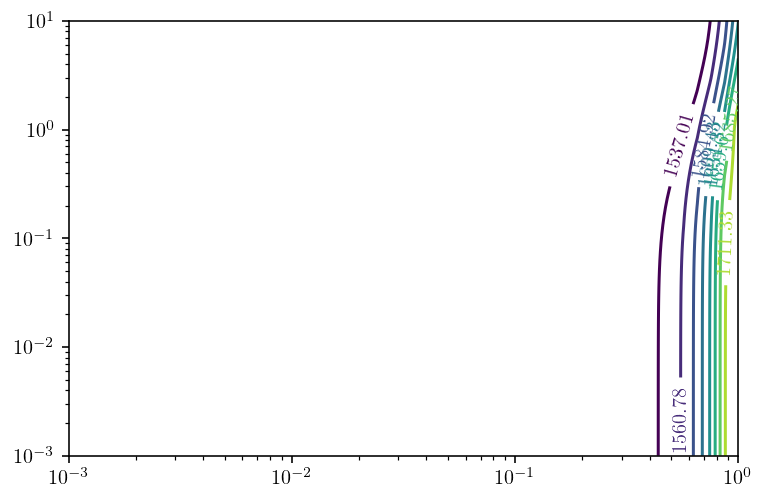

In [27]:
plt.xscale("log")
plt.yscale("log")
normal_contours(dist, r_s, mxs, plt.gca())

### $\rho_s$

In [32]:
rho_s_nfw = np.vectorize(rho_s_dampe)(dist_mg, r_s_mg, gamma_nfw, "nfw", mxs)

In [33]:
os.system("say 'Done computing rho'")

0

#### Checking results

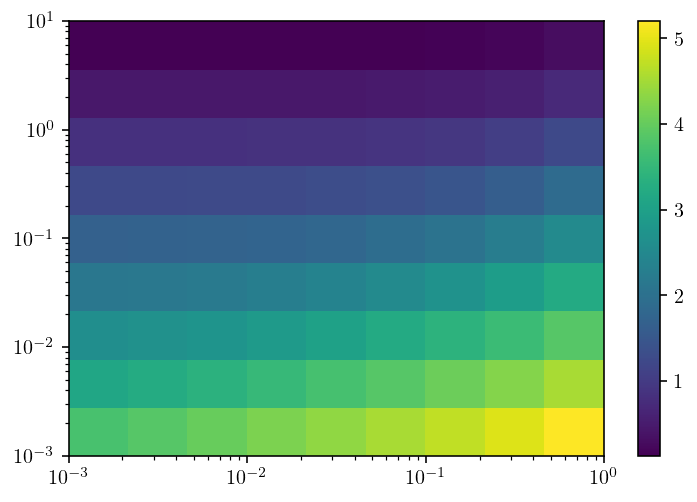

In [10]:
plt.xscale("log")
plt.yscale("log")
plt.pcolormesh(dist_mg, r_s_mg, np.log10(rho_s_nfw))
plt.colorbar()

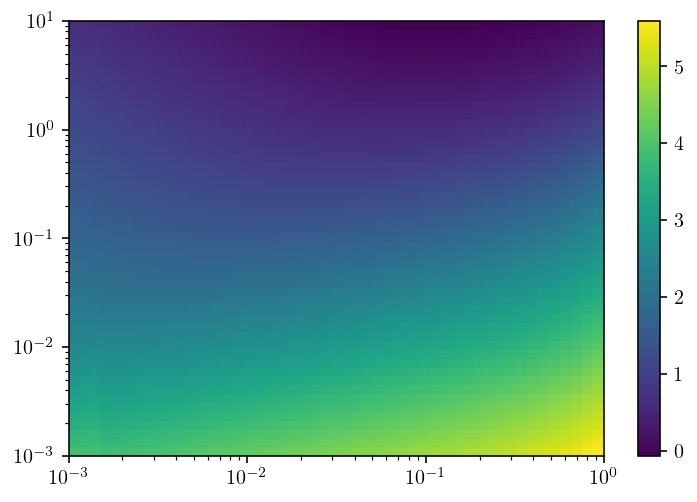

In [7]:
plt.xscale("log")
plt.yscale("log")
plt.pcolormesh(dist_mg, r_s_mg, np.log10(rho_s_nfw))
plt.colorbar()

#### Fill `nan`s by linearly interpolating along the $r_s$ axis

In [4]:
from scipy.interpolate import interp1d

for i in range(3):
    obs_idx = np.where(~np.isnan(rho_s_nfw[:, i]))[0]
    interp = interp1d(np.log(r_s[obs_idx]), np.log(rho_s_nfw[obs_idx, i]), fill_value="extrapolate")
    
    nan_idx = np.where(np.isnan(rho_s_nfw[:, i]))[0]
    rho_s_nfw[nan_idx, i] = np.exp(interp(np.log(r_s[nan_idx])))

### Halo mass

In [4]:
from nfw_clump import viral_radius

r_vir = viral_radius(r_s_mg, rho_s_nfw, gamma_nfw)

<a list of 7 text.Text objects>

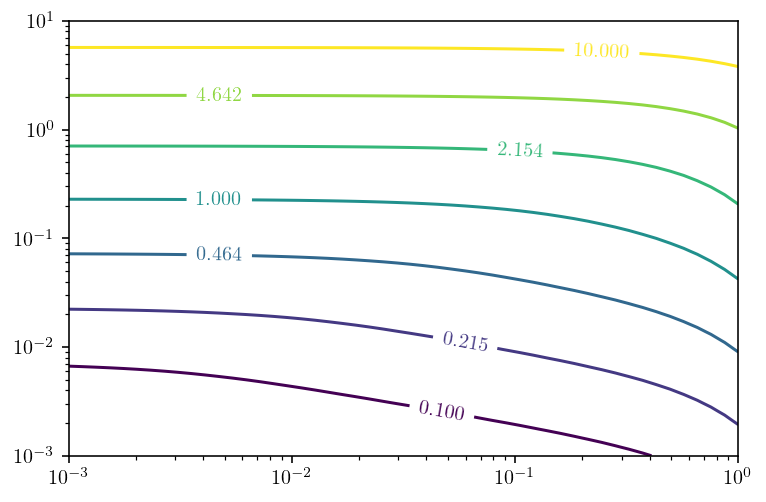

In [13]:
# levels = np.geomspace(1e3, 1e10, 8)
# clabels = {l: r"$%s~\mathrm{M}_{\mathrm{\odot}}$" % sci_fmt(l) for l in levels}

plt.xscale("log")
plt.yscale("log")

cs = plt.contour(dist, r_s, r_vir/5, norm=LogNorm(), levels=np.geomspace(0.1, 100, 10))
plt.clabel(cs, inline=True)

In [4]:
masses_nfw = mass(r_s_mg, rho_s_nfw, gamma_nfw, "nfw")

<a list of 7 text.Text objects>

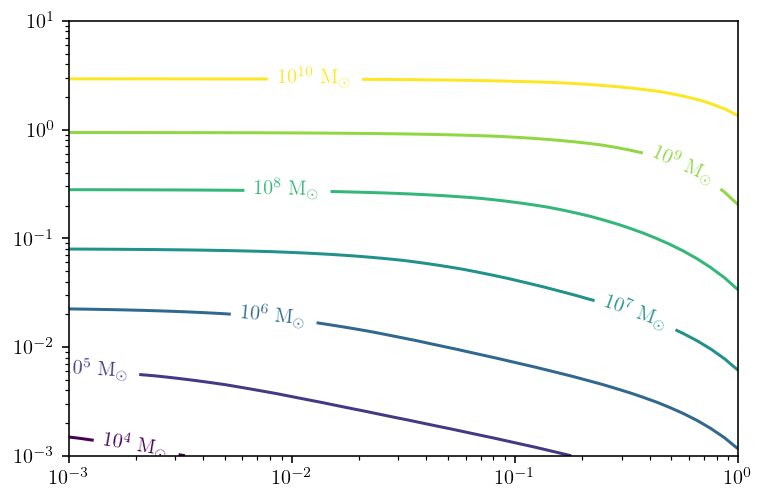

In [6]:
masses = masses_nfw

levels = np.geomspace(1e3, 1e10, 8)
clabels = {l: r"$%s~\mathrm{M}_{\mathrm{\odot}}$" % sci_fmt(l) for l in levels}

plt.xscale("log")
plt.yscale("log")

cs = plt.contour(dist, r_s, masses, levels=levels, norm=LogNorm())
plt.clabel(cs, inline=True, fmt=clabels)

### $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

In [39]:
rho_rel_nfw = (rho(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw") + rho_earth) / rho_earth

### $\mathcal{L}$

In [43]:
lum_nfw = luminosity(r_s_mg, rho_s_nfw, gamma_nfw, "nfw", mxs)

### $J$

In [44]:
from finite_clump_vectorized import J_factor
J_nfw = J_factor(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", fermi_psf)

#### Plot results

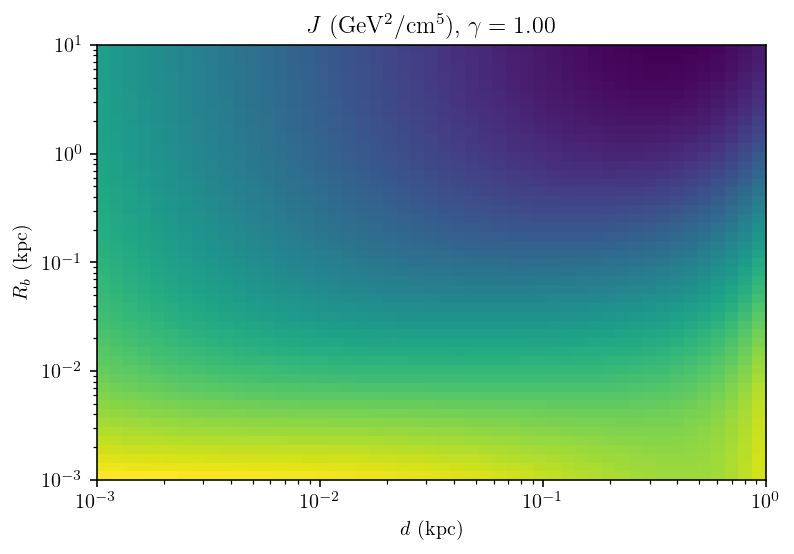

In [5]:
plt.xscale("log")
plt.yscale("log")
plt.title(r"$J$ (GeV$^2$/cm$^5$), $\gamma=%.2f$" % gamma_nfw)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_b$ (kpc)")

plt.pcolormesh(dist_mg, r_s_mg, np.log10(J_nfw))
# sci_contours(dist_mg, r_s_mg, J_nfw, plt.gca())
# plt.savefig("/Users/acoogan/Desktop/J_exp_1_08.pdf")

### $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 230$ GeV)

In [45]:
phi_g_nfw = phi_g(e_gamma_ref, dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", fermi_psf, mxs)

### $\frac{\theta_{68\%}}{\theta_{\mathrm{Fermi}}}$

In [14]:
extent_nfw = gamma_ray_extent(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw",
                              e_gamma_ref, thresh=0.68)

### Line width constraint

In [47]:
lw_nfw = np.vectorize(line_width_constraint)(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw")

In [121]:
lw_chi2_nfw = line_width_constraint_chi2(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw")

In [ ]:
for var in ["lw_chi2"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var + "_nfw"), delimiter=',')

In [122]:
os.system("say 'Done computing line width constraint'")

0

### Fermi point source non-detection constraint

In [27]:
rho_s_fermi_ps_nfw = fermi_point_src_contraint(dist_mg, r_s_mg, gamma_nfw, "nfw")

In [9]:
rho_s_fermi_ps_0_0_nfw = fermi_point_src_contraint(dist_mg, r_s_mg, gamma_nfw, "nfw",
                                                   fermi_pt_src_sens=fermi_pt_src_sens_0_0)

In [10]:
os.system("say 'Done computing point source constraint'")

0

### Comparison with Fermi EGB
Determine flux from $1^\circ$ observing region around clump relative to the Fermi EGB model. Since spectrum is harder than background model, set $E_\gamma \approx 1.5$ TeV.

In [51]:
th_ref = 1. * np.pi / 180  # 1 degree
phi_g_ext_nfw = phi_g(0.99*e_high_excess, dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", th_ref, mxs)
phi_g_ext_rel_nfw = phi_g_ext_nfw / phi_g_egb_fermi(e_high_excess)

In [85]:
os.system("say 'Done computing extended source constraint'")

0

#### Comparing definitions of the constraint

In [20]:
def phi_g_bubbles(es):
    def _helper(e):
        if e < 500:
            I = 6e-9
            alpha = 1.77
            beta= 0.063

            return I * (e / 10)**(-alpha - beta * np.log(e))
        else:
            return 0.
    return np.vectorize(_helper)(es)

In [27]:
e_gs_cyg = np.logspace(9, 11, 6) / 1e9
phi_g_cyg = np.array(6 * [10**(-4.25) / (1e3 * 0.7 * 2*np.pi)]) / e_gs_cyg

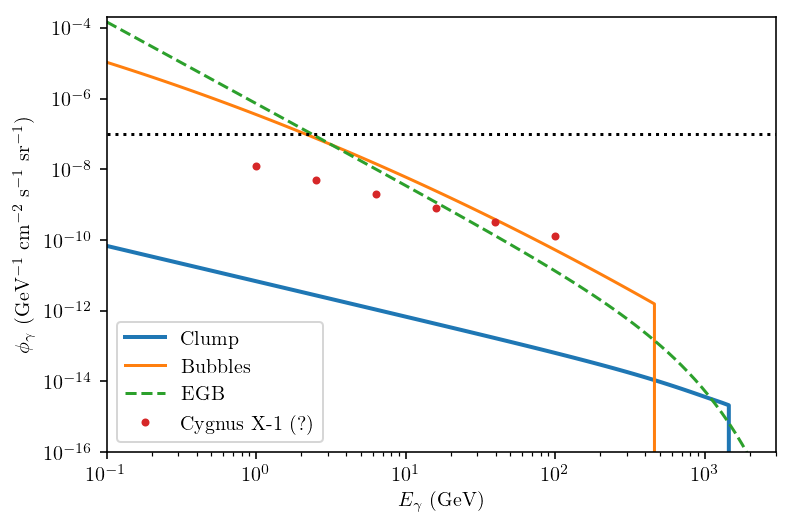

In [36]:
e_gs = np.logspace(-1, np.log10(3e3), 100)

plt.loglog(e_gs, phi_g(e_gs, 1e-2, 1e-2, 1e3, gamma_nfw, "nfw", 1*np.pi/180),
           label="Clump", linewidth=2)
plt.loglog(e_gs, phi_g_bubbles(e_gs), label="Bubbles")
plt.loglog(e_gs, phi_egb_fermi(e_gs), '--', label="EGB")
plt.loglog(e_gs_cyg, phi_g_cyg, '.', label="Cygnus X-1 (?)")
plt.axhline(1e-7, color='k', linestyle=':')

plt.autoscale(tight=True)
plt.ylim(1e-16, 2e-4)
plt.xlabel(r"$E_\gamma$ (GeV)")
plt.ylabel(r"$\phi_\gamma$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)")
plt.legend()

### Anisotropy

In [43]:
e_low, e_high = e_low_aniso_fermi[-1], e_high_aniso_fermi[-1]

try:
    anisos_nfw = anisotropy_integrated(
        e_low, e_high, dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", delta_d_rel=1e-4)
except:
    os.system("say 'anisotropy calculation failed'")

os.system("say 'calculation of anisotropies complete'")

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: overflow encountered in _phi_e (vectorized)
  outputs = ufunc(*inputs)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in _phi_e (vectorized)
  outputs = ufunc(*inputs)


0

#### Check results

In [47]:
anisos_nfw.min(), anisos_nfw.max(), aniso_fermi[-1]

(0.0001414469542571077, 0.01612065652552776, 0.02329275735661401)

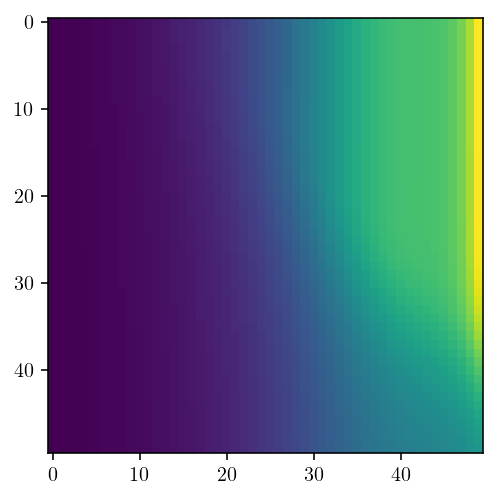

In [44]:
plt.imshow(anisos_nfw)

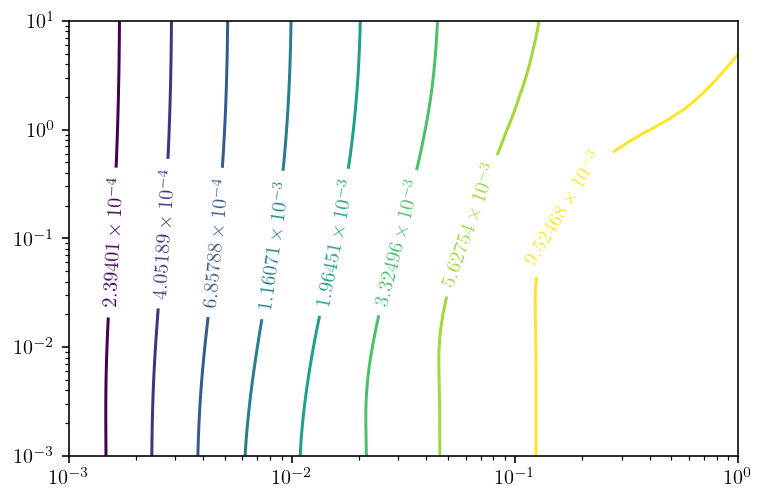

In [45]:
plt.xscale("log")
plt.yscale("log")
sci_contours(dist_mg, r_s_mg, anisos_nfw, ax=plt.gca(),
             levels=np.logspace(np.log10(anisos_nfw.min()), np.log10(anisos_nfw.max()), 10))

## Save results

In [16]:
for var in ["dist", "r_s"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var), delimiter=',')

 # , "lw_chi2", "extent", "mx", "anisos"]:
for var in ["rho_s", "rho_rel", "lum", "phi_g", "lw", "masses",
            "rho_s_fermi_ps", "rho_s_fermi_ps_0_0", "phi_g_ext_rel"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var + "_nfw"), delimiter=',')

In [20]:
# for var in ["lw_chi2"]:
#     np.savetxt(base_path_nfw + var + ".csv", eval(var + "_nfw"), delimiter=',')

## Plot everything together

In [32]:
levels_nfw = {}
levels_nfw[0.5] = {"lum": [1e31, 2e31, 7e31, 2e32, 5e32, 2e33, 4e33, 1e34, 4e34],
                   "rho_s": [1, 10, 1e2, 1e3, 1e4],
                   "phi_g": [2e-18, 1e-17, 1e-16, 1e-15, 1e-14, 4e-14, 1e-13],
                   "rho_rel": [1.1, 1.4, 2, 3, 10, 30, 100, 300, 1e3, 3e3],
                   "extent": [2, 5, 10, 20, 50, 100, 300, 500, 600, 650, 700],
                   "pr": np.arange(6.75, 8.25, 0.25)}
levels_nfw[1.0] = {"lum": [1e31, 2e31, 7e31, 2e32, 5e32, 2e33, 4e33, 1e34, 4e34],
                   "rho_s": [0.1, 1, 10, 1e2, 1e3, 1e4],
                   "phi_g": [5e-16, 1e-15, 3e-15, 1e-14, 3e-14, 1e-13, 1e-12, 1e-10, 1e-8],
                   "rho_rel": [1.1, 1.4, 2, 3, 10, 30, 100, 300, 1e3, 3e3],
                   "extent": [2, 5, 10, 20, 50, 100, 300, 450, 500, 515],
                   "pr": np.arange(4, 8, 0.5)}

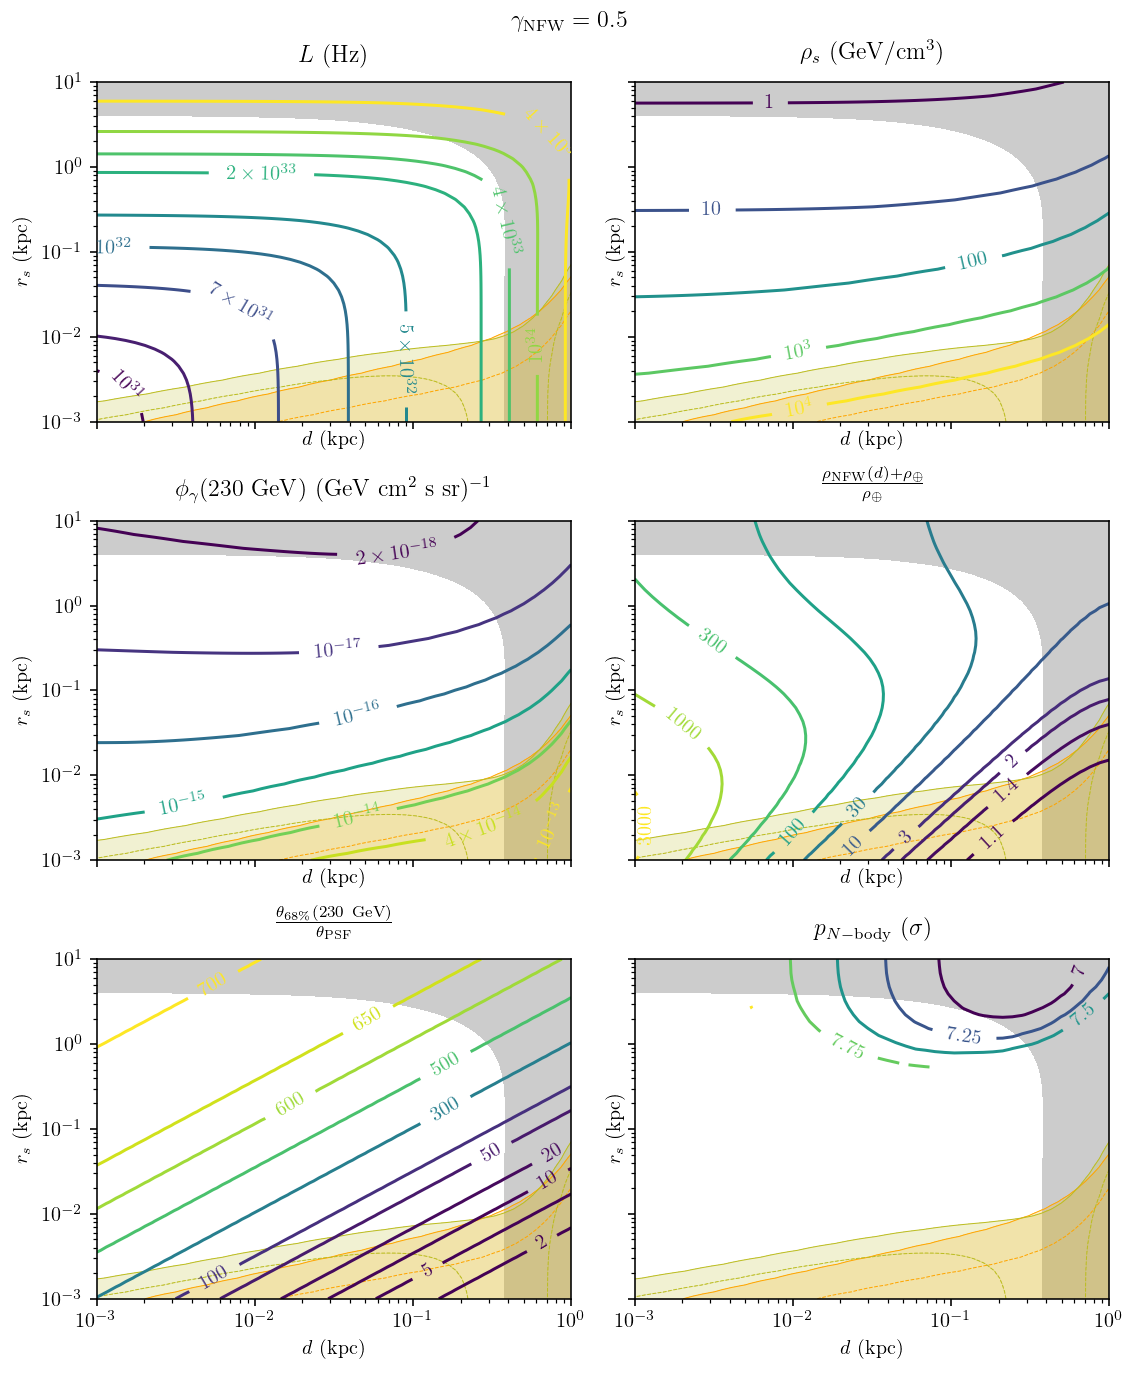

In [33]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

if gamma_nfw == 1:
    fig.suptitle(r"$\gamma_{\mathrm{NFW}} = " + "{:.0f}".format(gamma_nfw) + r"$")
elif gamma_nfw == 0.5:
    fig.suptitle(r"$\gamma_{\mathrm{NFW}} = " + "{:.1f}".format(gamma_nfw) + r"$")

for ax in axs.flatten():
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_s$ (kpc)")

    # Line width constraint (z-score)
    ax.contourf(dist_mg, r_s_mg, lw_nfw, levels=[n_sigma, np.max(lw_nfw)],
                colors='k', alpha=0.2)
    # Line width constraint (chi^2)
#     ax.contourf(dist_mg, r_s_mg, lw_chi2_nfw, levels=[chi2_crit + lw_chi2_ref, 1e5],
#                 colors='k', alpha=0.2)

    # Point source constraint
    ax.contourf(dist_mg, r_s_mg, rho_s_fermi_ps_nfw - rho_s_nfw, levels=[-1e100, 0],
                colors=["orange"], alpha=0.2)
    ax.contour(dist_mg, r_s_mg, rho_s_fermi_ps_nfw - rho_s_nfw, levels=[-1e100, 0],
               colors=["orange"], alpha=1, linewidths=0.5)
    ax.contour(dist_mg, r_s_mg, rho_s_fermi_ps_0_0_nfw - rho_s_nfw, levels=[-1e100, 0],
               colors=["orange"], linestyles="--", alpha=1, linewidths=0.5)

    # Extended source vs EGB
    ax.contourf(dist_mg, r_s_mg, phi_g_ext_rel_nfw, levels=[10, 20, 1e100],
                colors=[colors[8]], alpha=0.2)
    ax.contour(dist_mg, r_s_mg, phi_g_ext_rel_nfw, levels=[10, 20],
               colors=[colors[8]], linestyles=["-", "--"], alpha=1, linewidths=0.5)

ax = axs[0, 0]
# Must be done before plotting to get label formatting right.
# Only need to do this for one subplot.
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(dist[[0, -1]])
ax.set_ylim(r_s[[0, -1]])
ax.set_title(r"$L$ (Hz)", pad=10)
sci_contours(dist_mg, r_s_mg, lum_nfw, ax, levels=levels_nfw[gamma_nfw]["lum"])

ax = axs[0, 1]
ax.set_title(r"$\rho_s$ (GeV/cm$^3$)", pad=10)
sci_contours(dist_mg, r_s_mg, rho_s_nfw, ax, levels=levels_nfw[gamma_nfw]["rho_s"])

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
sci_contours(dist_mg, r_s_mg, phi_g_nfw, ax, levels=levels_nfw[gamma_nfw]["phi_g"])

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{NFW}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist_mg, r_s_mg, rho_rel_nfw, ax, levels=levels_nfw[gamma_nfw]["rho_rel"])

ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)
normal_contours(dist_mg, r_s_mg, extent_nfw/fermi_psf, ax,
                levels=levels_nfw[gamma_nfw]["extent"], norm=None)

ax = axs[2, 1]
ax.set_title(r"$p_{N {\rm -body}}$ $(\sigma)$", pad=10)
sci_contours(dist_pr, r_s_pr, pr_nfw, ax, levels=levels_nfw[gamma_nfw]["pr"])

fig.tight_layout(rect=[0, 0.03, 1, 0.975])
fig.savefig("figures/contour_plots_nfw_gamma_{}.pdf".format(
    "{:.1f}".format(gamma_nfw).replace(".", "-")))

In [24]:
os.system("say 'Done with NFW'")

0

# Exponential profile

In [31]:
# gamma_exp = 0.52  # 25th percentile
# gamma_exp = 0.74  # median
gamma_exp = 1.08  # 75th percentile

# Tightening up the plane (default: 50 points along each axis)
dist = np.logspace(-3, 0, 50)
r_s = np.logspace(-3, 1, 50)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

base_path_exp = 'data/fixed_mx/exp_gamma_%.2f/' % gamma_exp

## Load results

In [36]:
for var in ["dist", "r_s"]:
    exec(var + " = np.loadtxt('" + base_path_exp + var + ".csv', delimiter=',')")

dist_mg, r_s_mg = np.meshgrid(dist, r_s)

for var in ["rho_s", "rho_rel", "lum", "phi_g", "lw", "rho_s_fermi_ps_0_0", "masses",
            "rho_s_fermi_ps", "phi_g_ext_rel", "extent"]:
    exec(var + "_exp = np.loadtxt('" + base_path_exp + var + ".csv', delimiter=',')")

# Load likelihoods using Ben's processing
dist_pr, r_s_pr, pr_exp = np.genfromtxt(
    pr_base_path + "exp/sigmas_exp_gamma_%.2f.csv" % gamma_exp,
    delimiter=',').T

dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1).T
r_s_pr = r_s_pr.reshape(dist_pr.shape).T
pr_exp = pr_exp.reshape(dist_pr.shape).T

## Recompute

### Exploring numerical issues

* Prohibitively slow to incorporate the annihilation plateau into finding $\rho_s$ since that'd require using a root finder.
* Spectrum is hard to compute when $r_s / d$ is small.

In [3]:
from exp_clump import dphi_e_dr as dphi_e_dr_exp

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


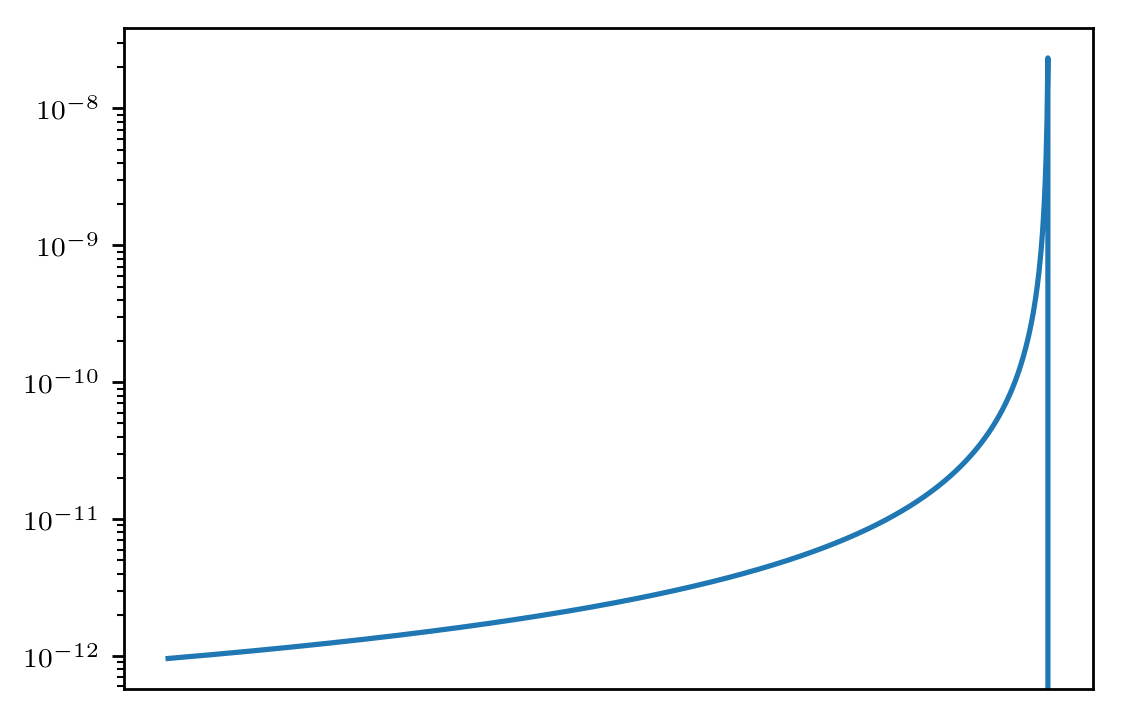

In [4]:
es = np.logspace(np.log10(e_low_excess), np.log10(mx), 1000)

dist, r_s = (0.0026826957952797246, 0.001)

plt.loglog(es, phi_e(es, dist, r_s, 1e5, gamma_exp, "exp"))

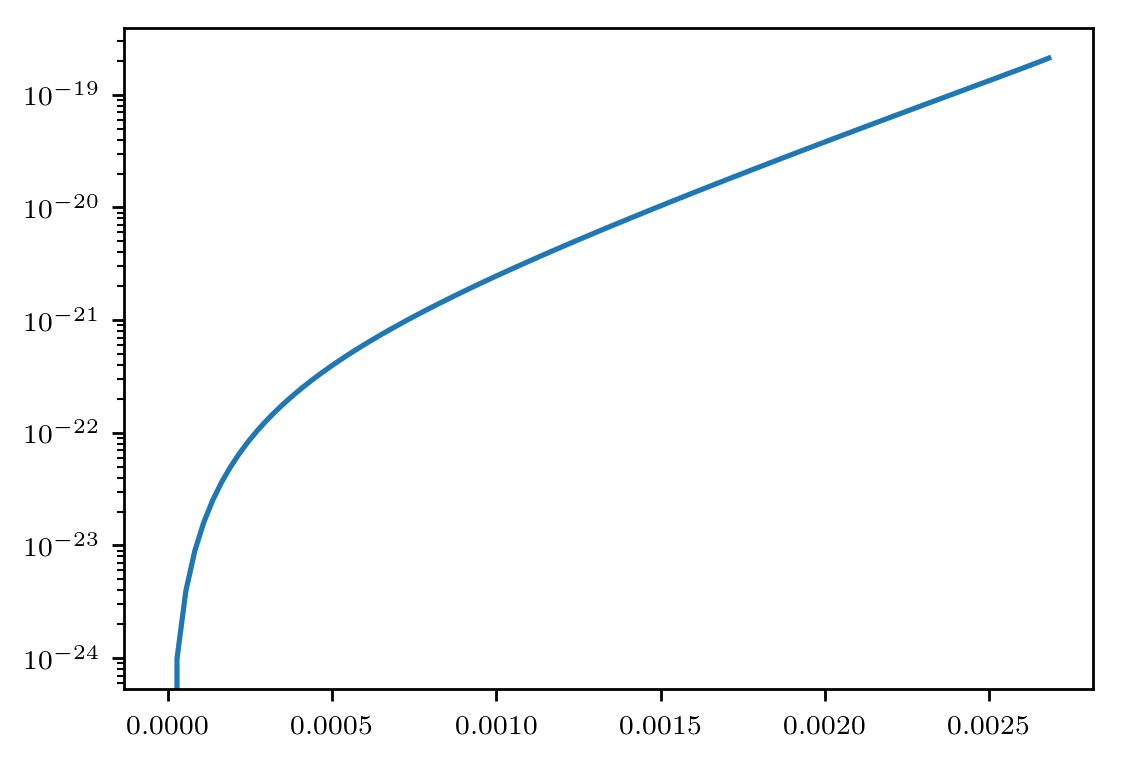

In [5]:
dist, r_s = (0.0026826957952797246, 0.001)
gamma_exp = 0.52
rs = np.linspace(0., dist, 100)

plt.plot(rs, np.vectorize(dphi_e_dr_exp)(rs, 1400, dist, r_s, 1., gamma_exp, mx, sv, fx))
plt.yscale("log")
# plt.ylim(1e-35, 1e-15)

### $\rho_s$

In [29]:
rho_s_exp = rho_s_dampe(dist_mg, r_s_mg, gamma_exp, "exp")

In [30]:
os.system("say 'Computed normalization'")

0

#### Plot results

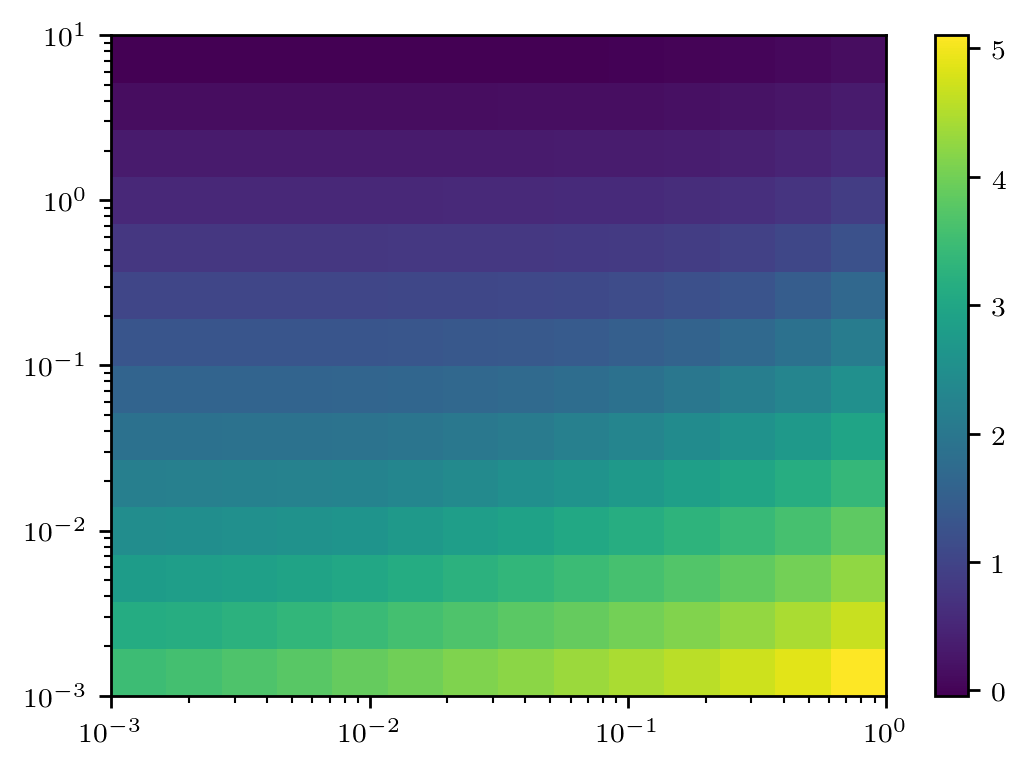

In [7]:
plt.xscale("log")
plt.yscale("log")
plt.pcolormesh(dist_mg, r_s_mg, np.log10(rho_s_exp))
plt.colorbar()

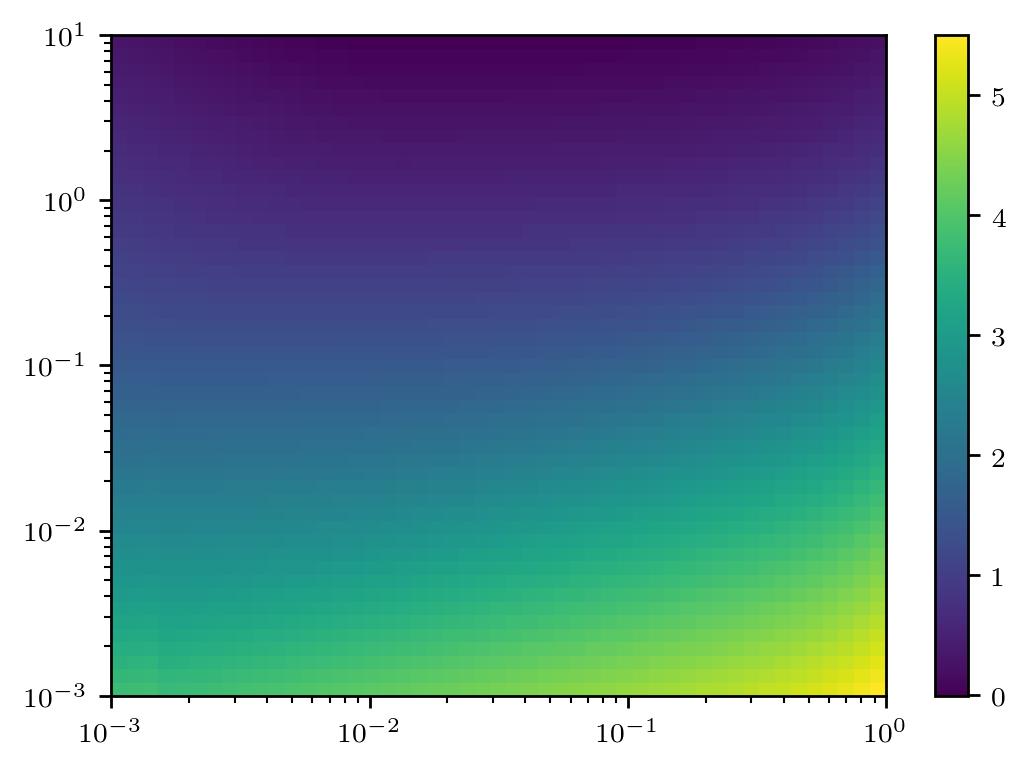

In [10]:
plt.xscale("log")
plt.yscale("log")
plt.pcolormesh(dist_mg, r_s_mg, np.log10(rho_s_exp))
plt.colorbar()

#### Interpolate numerical glitches

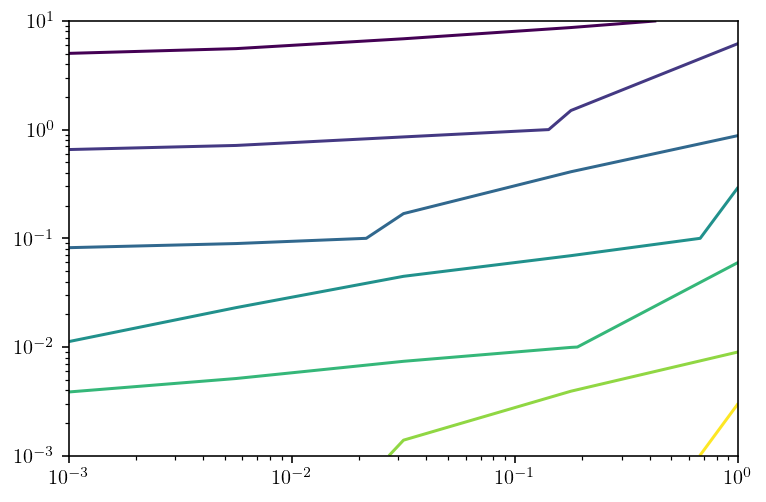

In [25]:
plt.xscale("log")
plt.yscale("log")
plt.contour(dist, r_s, np.log10(rho_s_exp))

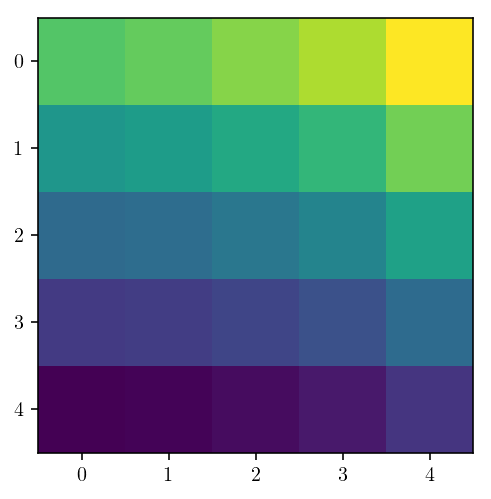

In [26]:
plt.imshow(np.log10(rho_s_exp))

#### Linearly interpolate nans

In [26]:
from scipy.interpolate import interp1d

for i in range(10, 15):
    obs_idx = np.where(~np.isnan(rho_s_exp[:, i]))[0]
    interp = interp1d(np.log(r_s[obs_idx]), np.log(rho_s_exp[obs_idx, i]),
                      fill_value="extrapolate")    
    nan_idx = np.where(np.isnan(rho_s_exp[:, i]))[0]
    rho_s_exp[nan_idx, i] = np.exp(interp(np.log(r_s[nan_idx])))

### Halo masses

In [33]:
masses_exp = mass(r_s_mg, rho_s_exp, gamma_exp, "exp")

### $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

In [31]:
rho_rel_exp = (rho(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp") + rho_earth) / rho_earth

### $\mathcal{L}$

In [32]:
lum_exp = luminosity(r_s_mg, rho_s_exp, gamma_exp, "exp")

### $J$

In [19]:
# from finite_clump_vectorized import J_factor
# J_exp = J_factor(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", fermi_psf)

#### Plot results

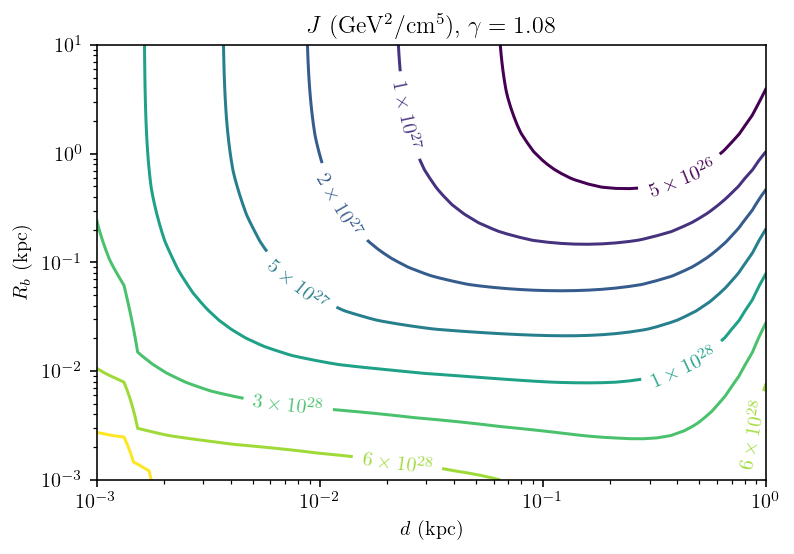

In [33]:
plt.xscale("log")
plt.yscale("log")
plt.title(r"$J$ (GeV$^2$/cm$^5$), $\gamma=1.08$")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_b$ (kpc)")

sci_contours(dist_mg, r_s_mg, J_exp, plt.gca())
plt.savefig("/Users/acoogan/Desktop/J_exp_1_08.pdf")

### $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 230$ GeV)

In [75]:
phi_g_exp = phi_g(e_gamma_ref, dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", fermi_psf)

#### Testing new definition of gamma-ray emission extent

In [61]:
phi_g_exp_1_deg = phi_g(e_gamma_ref, dist_mg, r_s_mg, rho_s_exp, gamma_exp,
                        "exp", 1. * np.pi / 180.)

In [78]:
phi_g_exp_tot = phi_g(e_gamma_ref, dist_mg, r_s_mg, rho_s_exp, gamma_exp,
                        "exp", np.pi)

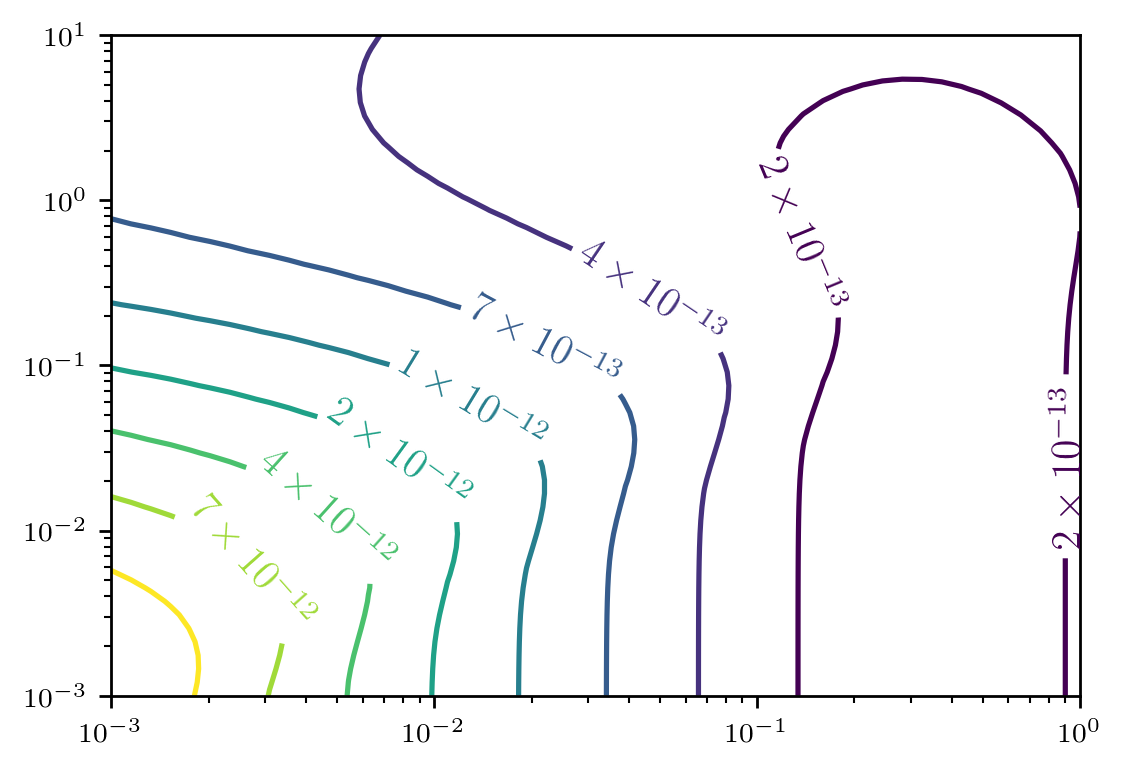

In [79]:
plt.xscale("log")
plt.yscale("log")
# plt.title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$")

sci_contours(dist_mg, r_s_mg, phi_g_exp_tot, ax=plt.gca())

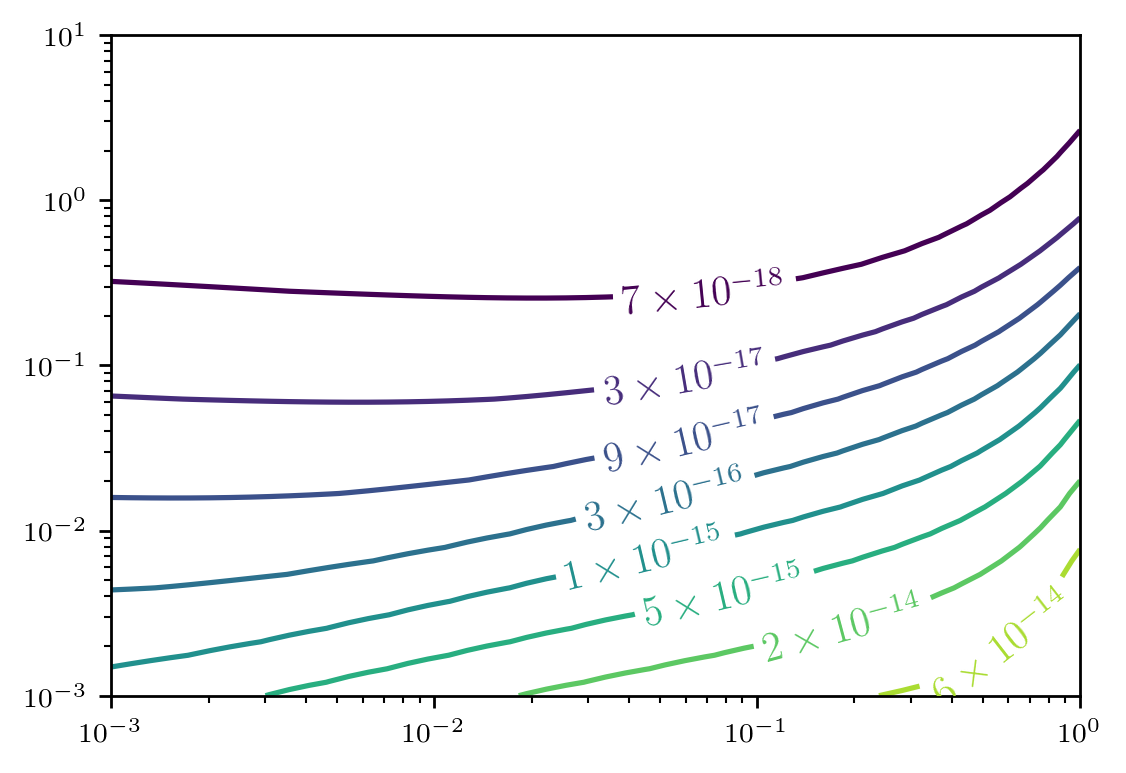

In [76]:
plt.xscale("log")
plt.yscale("log")
# plt.title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$")

sci_contours(dist_mg, r_s_mg, phi_g_exp,# / phi_g_exp,
             ax=plt.gca())

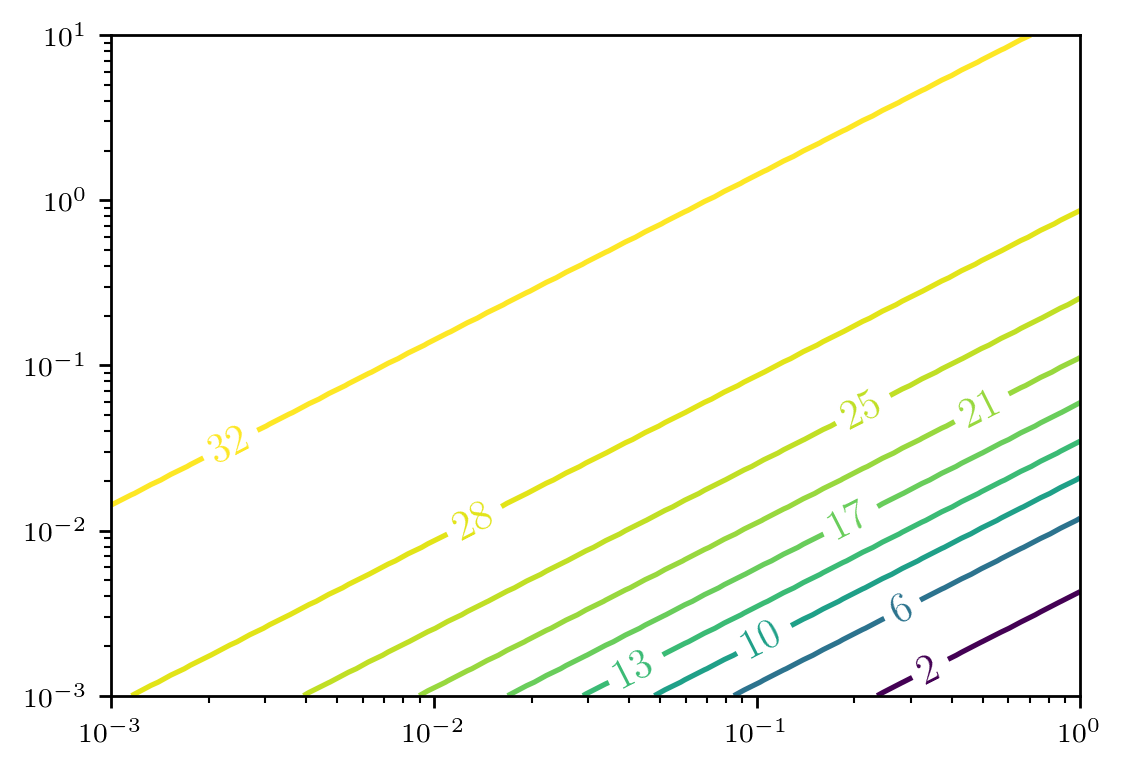

In [72]:
plt.xscale("log")
plt.yscale("log")
# plt.title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$")

normal_contours(dist_mg, r_s_mg, phi_g_exp_1_deg / phi_g_exp, ax=plt.gca(),
                levels=np.linspace(2, 36, 10))

In [34]:
os.system("say 'Computed photon flux'")

0

#### Annihilation plateau

In [ ]:
# from tt_clump import ann_plateau_radius as ann_plateau_radius_exp

# r_p_mg = ann_plateau_radius_exp(r_s_mg, rho_s_exp, gamma_exp)
# J_plateau_exp = 2*r_p_mg*rho_max**2*kpc_to_cm
# phi_g_exp = (fermi_psf_solid_angle/4/np.pi * 3e-26/2 / dampe_excess_bin_high**2 *
#                  dn_de_gamma_AP(e_gamma_ref, dampe_excess_bin_high) * J_plateau_exp)

### $\frac{\theta_{68\%}}{\theta_{\mathrm{Fermi}}}$

In [4]:
extent_exp = gamma_ray_extent(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp",
                              e_gamma_ref, thresh=0.68)
# except:
#     print('Not a bracketing interval')
#     os.system("say 'Not a bracketing interval'")

finite_clump_vectorized.py:183: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  J_near, err_near = quad(dJ_dr, 0., dist, args, points=points_near, epsabs=0, epsrel=1e-5)
finite_clump_vectorized.py:184: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on

In [5]:
os.system("say 'Done'")

0

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


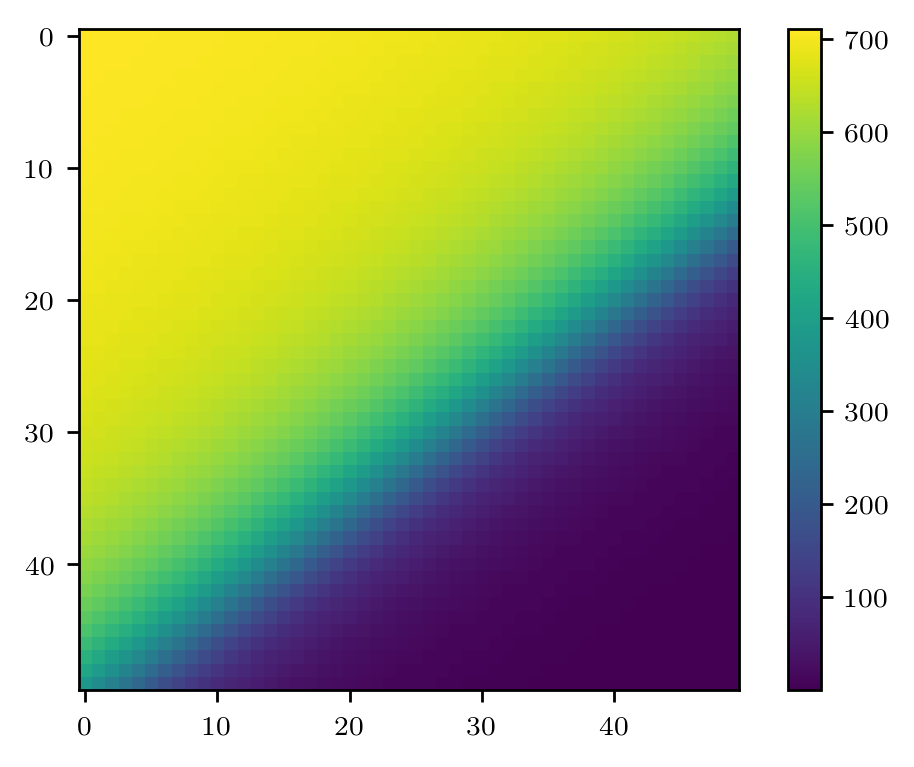

In [6]:
plt.imshow(extent_exp[::-1, :] / fermi_psf)
plt.colorbar()

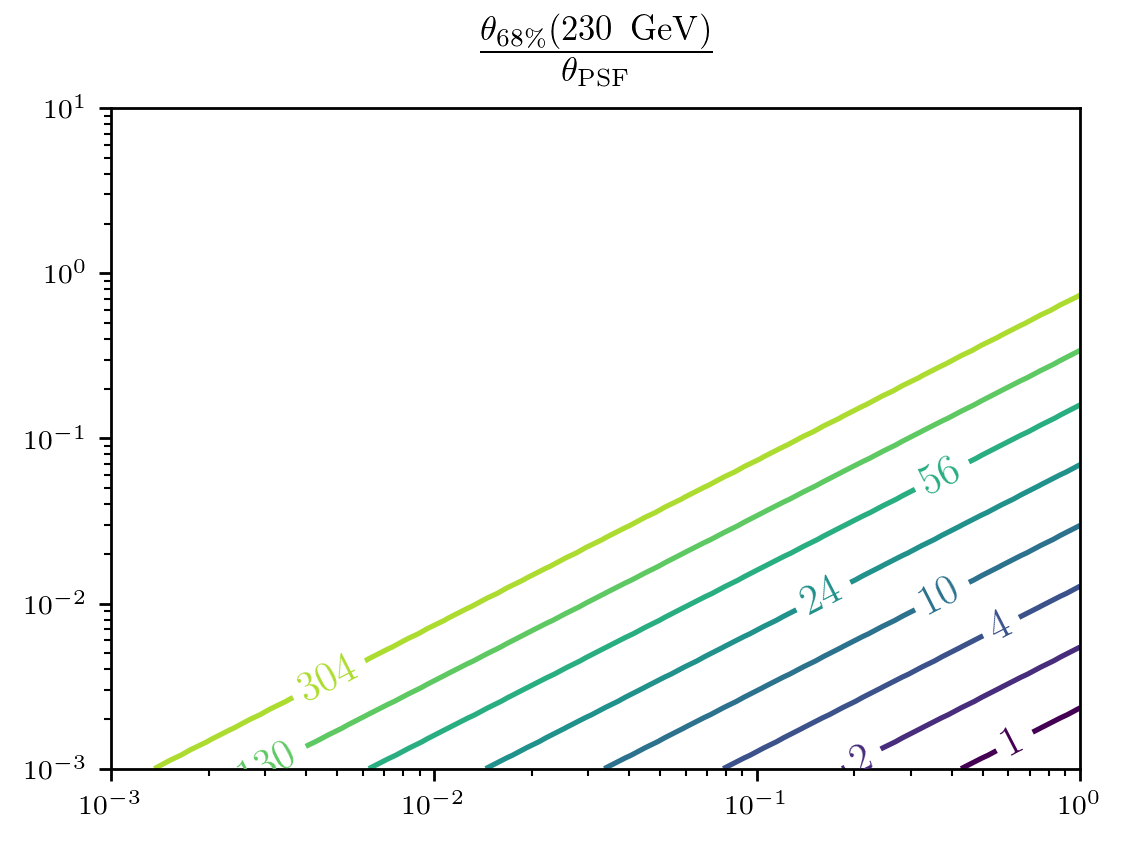

In [7]:
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$")

normal_contours(dist_mg, r_s_mg, extent_exp / fermi_psf, ax=plt.gca())

#### Fixing bracketing interval bug

In [52]:
dist[dist_idx], r_s[r_s_idx]

(0.13894954943731375, 0.001)

In [51]:
dist_idx = 35
r_s_idx = 0

In [53]:
phi_g(e_gamma_ref,
      dist_mg[r_s_idx, dist_idx],
      r_s_mg[r_s_idx, dist_idx],
      rho_s_exp[r_s_idx, dist_idx],
      gamma_exp, "exp", 1.) / phi_g(e_gamma_ref,
      dist_mg[r_s_idx, dist_idx],
      r_s_mg[r_s_idx, dist_idx],
      rho_s_exp[r_s_idx, dist_idx],
      gamma_exp, "exp", fermi_psf)

3.4771169793496255

In [40]:
gamma_ray_extent(dist_mg[r_s_idx, dist_idx],
                 r_s_mg[r_s_idx, dist_idx],
                 rho_s_exp[r_s_idx, dist_idx],
                 gamma_exp, "exp", e_gamma_ref, thresh=0.68) / fermi_psf

378.82911920409975

#### Ironing out the noise

In [31]:
extent_exp_coarse = gamma_ray_extent(dist_mg[::3, ::3], r_s_mg[::3, ::3],
                                     rho_s_exp[::3, ::3], gamma_exp, "exp",
                                     e_gamma_ref, thresh=0.68)

NameError: name 'levels_exp' is not defined

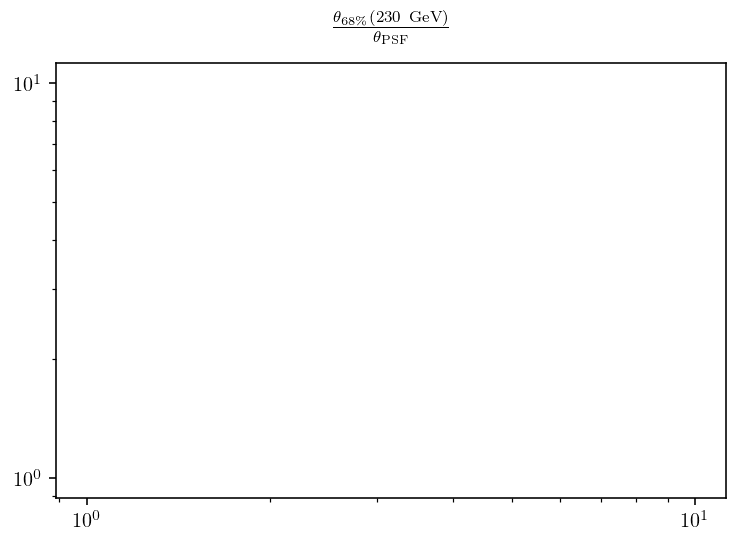

In [32]:
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)

plt.contour(dist[::3], r_s[::3], extent_exp_coarse/fermi_psf,
            levels=levels_exp[gamma_exp]["extent"])

In [ ]:
os.system("say 'Done'")

### Line width constraint

In [35]:
lw_exp = line_width_constraint(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", n_sigma)

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: overflow encountered in _phi_e (vectorized)
  outputs = ufunc(*inputs)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in _phi_e (vectorized)
  outputs = ufunc(*inputs)


In [36]:
os.system("say 'Computed line width constraint'")

0

### Fermi point source non-detection constraint

In [37]:
rho_s_fermi_ps_exp = fermi_point_src_contraint(dist_mg, r_s_mg, gamma_exp, "exp")

In [34]:
rho_s_fermi_ps_0_0_exp = fermi_point_src_contraint(dist_mg, r_s_mg, gamma_nfw, "exp",
                                                   fermi_pt_src_sens=fermi_pt_src_sens_0_0)

In [38]:
os.system("say 'Computed point source constraint'")

0

### Comparison with Fermi EGB
Determine flux from $1^\circ$ observing region around clump relative to the Fermi EGB model. Since spectrum is harder than background model, set $E_\gamma \approx 1.5$ TeV.

In [40]:
th_ref = 1. * np.pi / 180  # 1 degree
phi_g_ext_exp = phi_g(0.99*e_high_excess, dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", th_ref)
phi_g_ext_rel_exp = phi_g_ext_exp / phi_g_egb_fermi(e_high_excess)

In [39]:
os.system("say 'Computed extended source constraint'")

0

#### Comparing definitions of the constraint

In [4]:
def phi_g_bubbles(es):
    def _helper(e):
        if e < 500:
            I = 6e-9
            alpha = 1.77
            beta= 0.063

            return I * (e / 10)**(-alpha - beta * np.log(e))
        else:
            return 0.
    return np.vectorize(_helper)(es)

In [5]:
e_gs_cyg = np.logspace(9, 11, 6) / 1e9
phi_g_cyg = np.array(6 * [10**(-4.25) / (1e3 * 0.7 * 2*np.pi)]) / e_gs_cyg

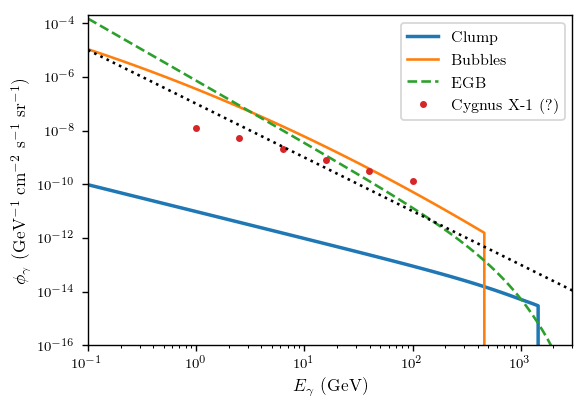

In [10]:
e_gs = np.logspace(-1, np.log10(3e3), 100)

plt.loglog(e_gs, phi_g(e_gs, 1e-2, 1e-2, 1e3, gamma_exp, "exp", 1*np.pi/180),
           label="Clump", linewidth=2)
plt.loglog(e_gs, phi_g_bubbles(e_gs), label="Bubbles")
plt.loglog(e_gs, phi_egb_fermi(e_gs), '--', label="EGB")
plt.loglog(e_gs_cyg, phi_g_cyg, '.', label="Cygnus X-1 (?)")
plt.loglog(e_gs, 1e-7 / e_gs**2, color='k', linestyle=':')

plt.autoscale(tight=True)
plt.ylim(1e-16, 2e-4)
plt.xlabel(r"$E_\gamma$ (GeV)")
plt.ylabel(r"$\phi_\gamma$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)")
plt.legend()

### Anisotropy

In [55]:
e_low, e_high = e_low_aniso_fermi[-1], e_high_aniso_fermi[-1]

try:
    anisos_exp = anisotropy_integrated(
        e_low, e_high, dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", delta_d_rel=1e-4)
except:
    os.system("say 'anisotropy calculation failed'")

os.system("say 'calculation of anisotropies complete'")

finite_clump_vectorized.py:143: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  epsabs=0, epsrel=epsrel, limit=limit)
finite_clump_vectorized.py:143: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  epsabs=0, epsrel=epsrel, limit=limit)


0

#### Check results

In [14]:
anisos_exp.min(), anisos_exp.max(), aniso_fermi[-1]

(0.003387073001152538, 0.2003632944847847, 0.02329275735661401)

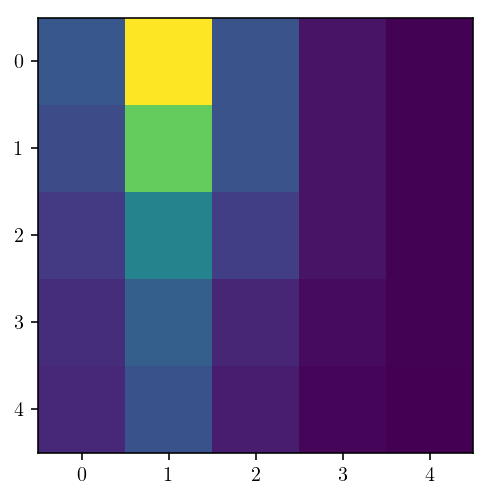

In [11]:
plt.imshow(anisos_exp)

TypeError: Shape of x does not match that of z: found (50, 50) instead of (5, 5).

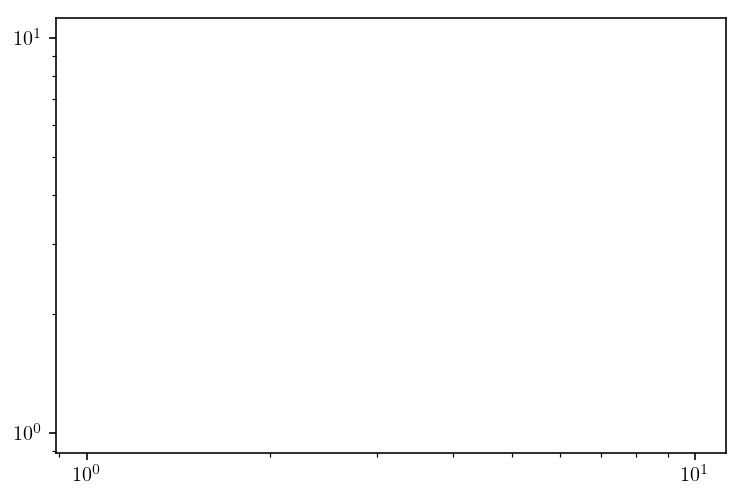

In [12]:
plt.xscale("log")
plt.yscale("log")
sci_contours(dist_mg, r_s_mg, anisos_exp, ax=plt.gca(),
             levels=np.logspace(np.log10(anisos_exp.min()), np.log10(anisos_exp.max()), 10))

## Save results

In [35]:
for var in ["dist", "r_s"]:
    np.savetxt(base_path_exp + var + ".csv", eval(var), delimiter=',')

for var in ["rho_s", "rho_rel", "lum", "phi_g", "extent",  "masses",
            "lw", "rho_s_fermi_ps", "phi_g_ext_rel", "rho_s_fermi_ps_0_0"]:
    np.savetxt(base_path_exp + var + ".csv", eval(var + "_exp"), delimiter=',')

## Plot everything together

In [51]:
levels_exp = {}
levels_exp[0.52] = {"lum": [3e31, 1e32, 3e32, 1e33, 3e33, 7e33, 3e34, 1e35],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "phi_g": [2e-18, 4e-18, 1e-17, 1e-16, 1e-15, 1e-14, 1e-13],
                    "rho_rel": [1.001, 1.1, 2, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 600, 650, 680, 700],
                    "pr": sorted(np.append(np.arange(4, 8, 0.5), 4.2))}
levels_exp[0.74] = {"lum": [3e31, 1e32, 3e32, 1e33, 3e33, 7e33, 3e34, 1e35],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "phi_g": [2e-17, 5e-17, 1e-16, 3e-16, 1e-15, 3e-15,
                              1e-14, 3e-14, 1e-13],
                    "rho_rel": [1.001, 1.1, 2, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 550, 600, 630],
                    "pr": np.arange(4, 8, 0.5)}
levels_exp[1.08] = {"lum": [1e31, 3e31, 1e32, 3e32, 1e33, 3e33, 7e33, 2e34],
                    "rho_s": [0.1, 1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "phi_g": [1e-15, 3e-15, 1e-14, 3e-14, 1e-13],
                    "rho_rel": [1.001, 1.1, 2, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 300, 400, 450, 470],
                    "pr": sorted(np.append(np.arange(3.5, 8, 0.5), 3.75))}

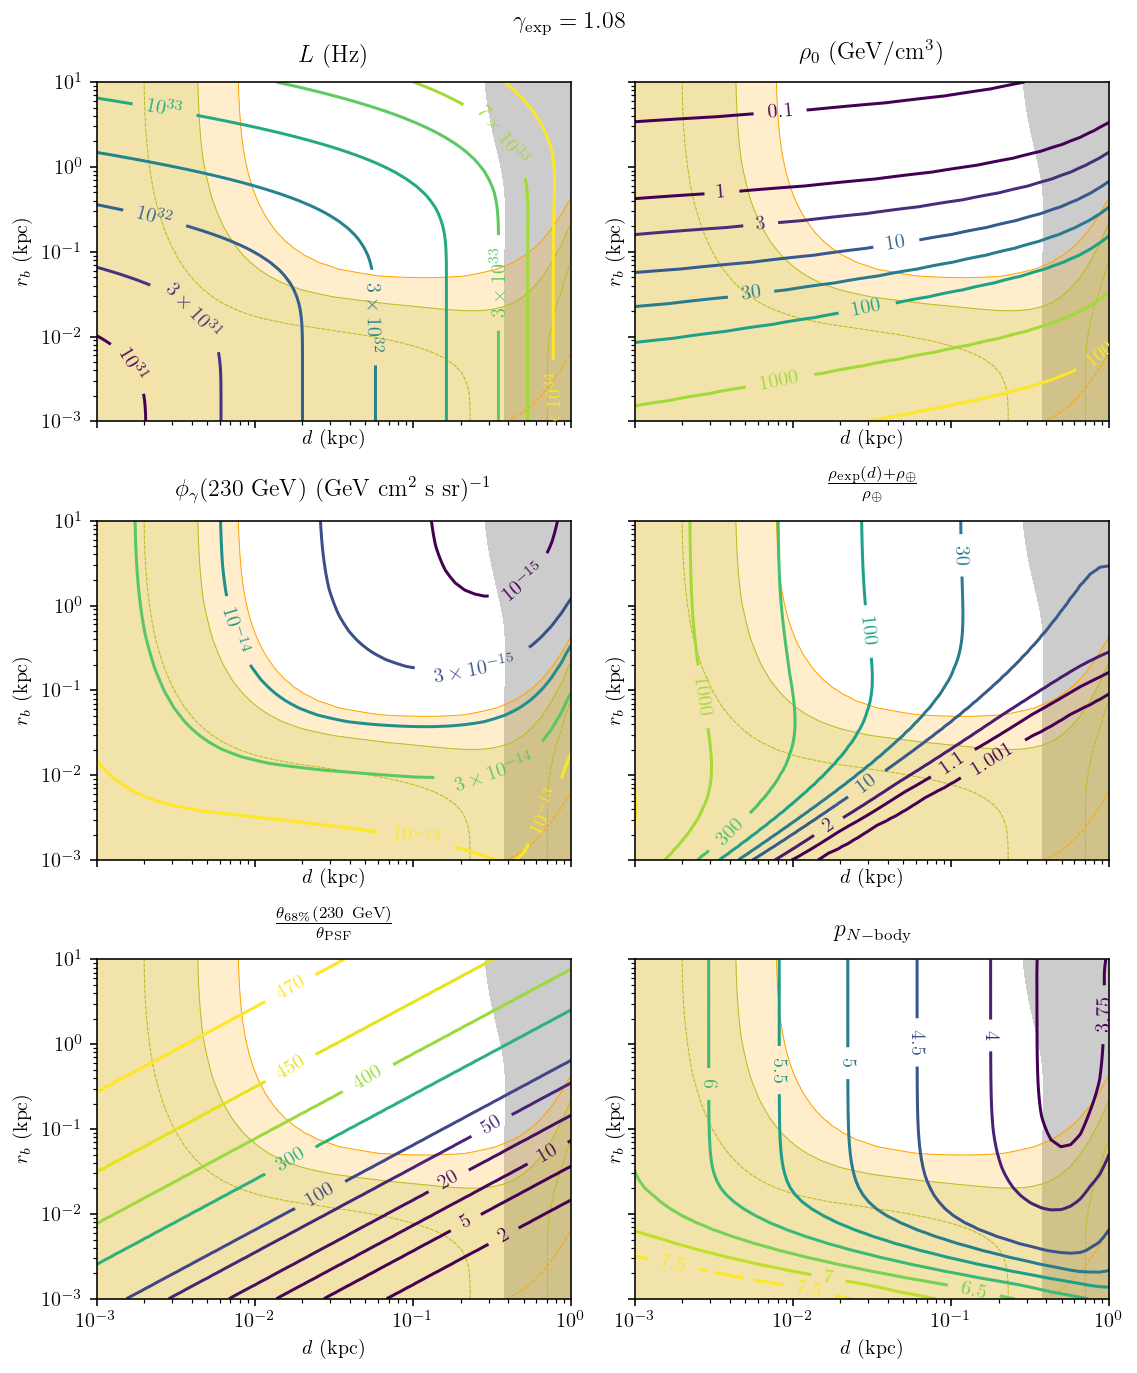

In [55]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

fig.suptitle(r"$\gamma_{\mathrm{exp}} = %.2f$" % gamma_exp)

for ax in axs.flatten():
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_b$ (kpc)")
    
    # Line width constraint
    ax.contourf(dist_mg, r_s_mg, lw_exp, levels=[n_sigma, np.max(lw_exp)],
                colors='k', alpha=0.2)
    
    # Point source constraint
    ax.contourf(dist_mg, r_s_mg, rho_s_fermi_ps_exp - rho_s_exp, levels=[-1e100, 0],
                colors=["orange"], alpha=0.2)
    ax.contour(dist_mg, r_s_mg, rho_s_fermi_ps_exp - rho_s_exp, levels=[-1e100, 0],
               colors=["orange"], alpha=1, linewidths=0.5)
    ax.contour(dist_mg, r_s_mg, rho_s_fermi_ps_0_0_exp - rho_s_exp, levels=[-1e100, 0],
               colors=["orange"], linestyles="--", alpha=1, linewidths=0.5)

    # Extended source vs EGB
    ax.contourf(dist_mg, r_s_mg, phi_g_ext_rel_exp, levels=[10, 20, 1e100],
                colors=[colors[8]], alpha=0.2)
    ax.contour(dist_mg, r_s_mg, phi_g_ext_rel_exp, levels=[10, 20],
               colors=[colors[8]], linestyles=["-", "--"], alpha=1, linewidths=0.5)

ax = axs[0, 0]
# Must be done before plotting to get label formatting right.
# Only need to do this for one subplot.
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(dist[[0, -1]])
ax.set_ylim(r_s[[0, -1]])
ax.set_title(r"$L$ (Hz)", pad=10)
sci_contours(dist_mg, r_s_mg, lum_exp, ax, levels=levels_exp[gamma_exp]["lum"])

ax = axs[0, 1]
ax.set_title(r"$\rho_0$ (GeV/cm$^3$)", pad=10)
normal_contours(dist_mg, r_s_mg, rho_s_exp, ax, levels=levels_exp[gamma_exp]["rho_s"])

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
sci_contours(dist_mg, r_s_mg, phi_g_exp, ax, levels=levels_exp[gamma_exp]["phi_g"])

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{exp}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist_mg, r_s_mg, rho_rel_exp, ax, levels=levels_exp[gamma_exp]["rho_rel"])

ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)
normal_contours(dist_mg, r_s_mg, extent_exp/fermi_psf, ax,
                levels=levels_exp[gamma_exp]["extent"], norm=None)

ax = axs[2, 1]
ax.set_title(r"$p_{N{\rm -body}}$", pad=10)
sci_contours(dist_pr, r_s_pr, pr_exp, ax, levels=levels_exp[gamma_exp]["pr"])

fig.tight_layout(rect=[0, 0.03, 1, 0.975])
fig.savefig("figures/contour_plots_exp_gamma_{}.pdf".format(
    "{:.2f}".format(gamma_exp).replace(".", "-")))

# Halo masses

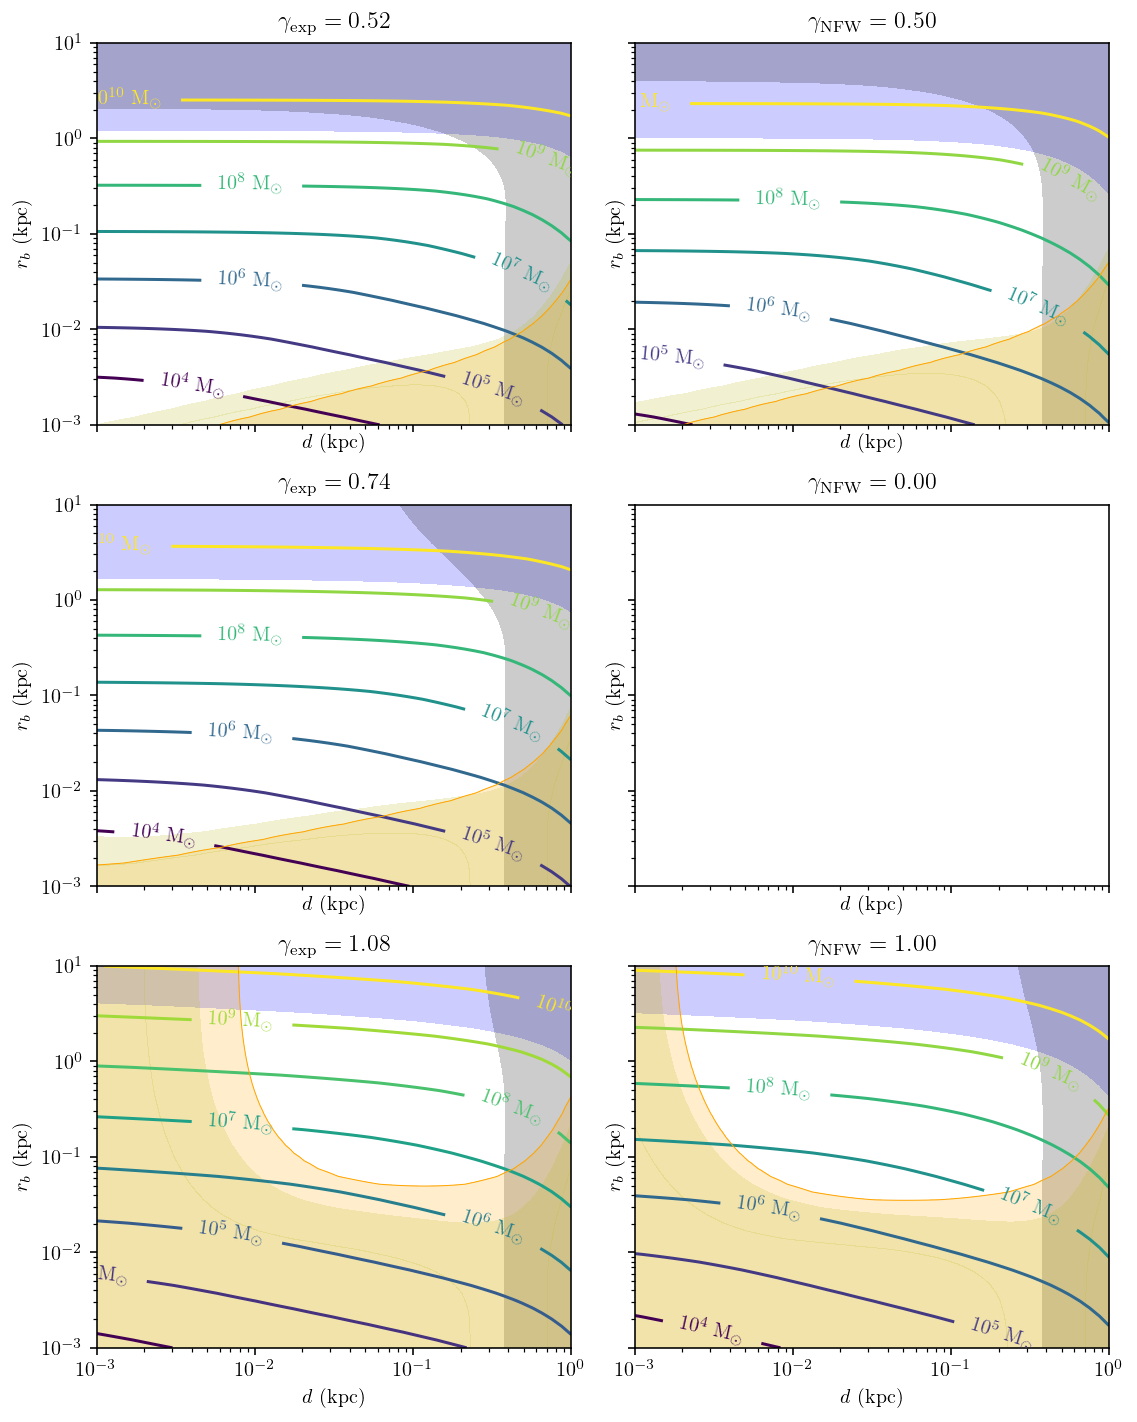

In [77]:
gamma_exps = [0.52, 0.74, 1.08]
gamma_nfws = [0.5, 0, 1.0]
# Same for all halos
dist = np.loadtxt(base_path_exp + "dist.csv", delimiter=",")
r_s = np.loadtxt(base_path_exp + "r_s.csv", delimiter=",")
dist_mg, r_s_mg = np.meshgrid(dist, r_s)
levels = np.geomspace(1e3, 1e10, 8)
clabels = {l: r"$%s~\mathrm{M}_{\mathrm{\odot}}$" % sci_fmt(l) for l in levels}
mass_constraint = 4/3 * np.pi * 4e3**3 * (3 * 0.003)  # M_sun

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(8, 10))

for col in range(axes.shape[1]):
    
    for row in range(axes.shape[0]):
        try:
            gamma = gamma_exps[row] if col == 0 else gamma_nfws[row]
            ax = axes[row, col]
            
            # Path to data
            base_path = "data/fixed_mx/exp_gamma_" if col == 0 else "data/fixed_mx/nfw_gamma_"
            if col == 0:
                base_path = "%s%.2f/" % (base_path, gamma)
            else:
                base_path = "%s%.1f/" % (base_path, gamma)
            
            # Format
            ax.set_xlim(dist[[0, -1]])
            ax.set_ylim(r_s[[0, -1]])
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xlabel(r"$d$ (kpc)")
            ax.set_ylabel(r"$r_b$ (kpc)")
            if col == 0:
                ax.set_title(r"$\gamma_{\mathrm{exp}} = %.2f$" % gamma)
            else:
                ax.set_title(r"$\gamma_{\mathrm{NFW}} = %.2f$" % gamma)
            
            # Load grids
            masses = np.loadtxt(base_path + "masses.csv", delimiter=",")
            lw = np.loadtxt(base_path + "lw.csv", delimiter=",")
            phi_g_ext_rel = np.loadtxt(base_path + "phi_g_ext_rel.csv", delimiter=",")
            rho_s = np.loadtxt(base_path + "rho_s.csv", delimiter=",")
            rho_s_fermi_ps = np.loadtxt(base_path + "rho_s_fermi_ps.csv", delimiter=",")
            
            # Mass contours
            cs = ax.contour(dist, r_s, masses, levels=levels, norm=LogNorm())
            ax.clabel(cs, inline=True, fmt=clabels)
            
            # Rough local density constraint
            ax.contourf(dist_mg, r_s_mg, masses, levels=[mass_constraint, 1e100],
                        colors=["blue"], alpha=0.2)

            # Line width constraint
            ax.contourf(dist_mg, r_s_mg, lw, levels=[n_sigma, np.max(lw_exp)],
                        colors='k', alpha=0.2)

            # Point source constraint
            ax.contourf(dist_mg, r_s_mg, rho_s_fermi_ps - rho_s, levels=[-1e100, 0],
                        colors=["orange"], alpha=0.2)
            ax.contour(dist_mg, r_s_mg, rho_s_fermi_ps - rho_s, levels=[-1e100, 0],
                       colors=["orange"], alpha=1, linewidths=0.5)

            # Extended source vs EGB
            ax.contourf(dist_mg, r_s_mg, phi_g_ext_rel, levels=[10, 20, 1e100],
                        colors=[colors[8]], alpha=0.2)
        except:
            pass

fig.tight_layout()
fig.savefig("figures/masses.pdf")

# Exponential profile likelihoods over $\gamma$ grid

In [8]:
# Load likelihoods using Ben's processing
dist_pr, r_s_pr, pr_exp = np.genfromtxt(
    pr_base_path + "exp/sigmas_exp_gamma_grid.csv",
    delimiter=',').T

dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1).T
r_s_pr = r_s_pr.reshape(dist_pr.shape).T
pr_exp = pr_exp.reshape(dist_pr.shape).T

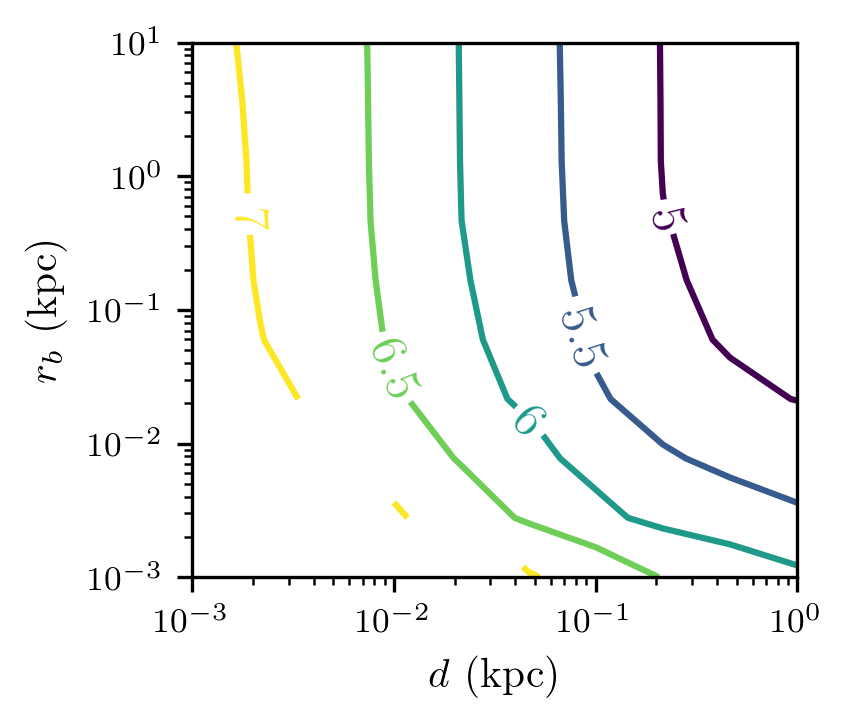

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2.6))

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$d$ (kpc)")
ax.set_ylabel(r"$r_b$ (kpc)")
ax.set_xlim(dist_pr.min(), dist_pr.max())
ax.set_ylim(r_s_pr.min(), r_s_pr.max())
# ax.set_title(r"$p_{N{\rm -body}}$", pad=10)

sci_contours(dist_pr, r_s_pr, pr_exp, ax, levels=np.arange(4.5, 7.5, 0.5))

fig.tight_layout()
fig.savefig("figures/likelihoods_exp_gamma_grid.pdf")

# Extreme power law profile

In [2]:
from pointlike_clump import line_width_constraint as line_width_constraint_pt
from pointlike_clump import lum_dampe as lum_dampe_pt
from pointlike_clump import phi_e as phi_e_pt
from pointlike_clump import phi_g as phi_g_pt
from pointlike_clump import anisotropy_integrated as anisotropy_integrated_pt

from power_law_clump import ann_plateau_radius as ann_plateau_radius_pl
from power_law_clump import lum as lum_pl
from power_law_clump import rho as rho_pl

In [12]:
gamma_pl = 3/2.
# gamma_pl = 9/4.
dist = np.logspace(-3, 0, 50)
r_tr = np.logspace(-3, 1, 50)
dist_mg, r_tr_mg = np.meshgrid(dist, r_tr)

base_path_pl = 'data/pl_gamma_%.2f/' % gamma_pl

## Compute everything

Point-source luminosities

In [13]:
lum_pt = lum_dampe_pt(dist)
lum_pt = np.stack(r_tr.shape[0]*[lum_pt])
lum_pt[lum_pt < 0] = np.nan

Annihilation plateau radii

In [14]:
r_p = ann_plateau_radius_pl(r_tr_mg, lum_pt, gamma_pl)

Local density enhancement

In [15]:
rho_rel_pl = (rho_pl(dist_mg, r_p, r_tr_mg, gamma_pl) + rho_earth) / rho_earth

Gamma ray flux from power law clump

In [16]:
if gamma_pl == 9/4.:
    # Integrate out to a few times r_p. Taking a larger bound for this integration
    # doesn't impact J.
    r_cut_mg = fermi_psf * dist_mg
    J_factors = 1 / fermi_psf_solid_angle / dist_mg**2
    J_factors *= (4*np.pi/(9.-6.*gamma_pl) * rho_max**2 *
                  (3 * r_cut_mg**3 * (r_p / r_cut_mg)**(2*gamma_pl) -
                   2*gamma_pl*r_p**3)) * kpc_to_cm
elif gamma_pl == 3/2.:
    _, _, J_factors = np.loadtxt(base_path_pl + "d_rtr_j.csv", delimiter=",").T
    J_factors = J_factors.reshape(dist_mg.shape).T
    
phi_g_pl = (fermi_psf_solid_angle/(4*np.pi) * sv / (2*fx*mx**2) * dn_de_g_ap(e_gamma_ref, mx) * J_factors)
phi_g_pl[phi_g_pl < 0] = np.nan

Line width constraint for a point-like clump

In [17]:
# This constraint uses the point-like electron spectrum. Since the luminosity is
# only dependent on distance, we don't need to vary the other parameters.
lw_pt = line_width_constraint_pt(dist_mg[0], lum_pt[0], n_sigma)
lw_pt = np.stack(r_tr.shape[0]*[lw_pt])
lw_pt[lw_pt < 0] = np.nan

Anisotropy constraint for a point-like clump

In [18]:
e_low, e_high = e_low_aniso_fermi[-1], e_high_aniso_fermi[-1]
anisos_pt = anisotropy_integrated_pt(e_low, e_high, dist_mg[0], lum_pt[0])
anisos_pt = np.stack(r_tr.shape[0]*[anisos_pt])
anisos_pt[anisos_pt < 0] = np.nan

## Plot everything together

In [19]:
levels_pl = {}
levels_pl[1.50] = {"lum": [7e30, 1e31, 3e31, 1e32, 3e32, 1e33, 1e34],
                   "r_p": [3e-9, 6e-9, 1e-8, 2e-8, 3e-8],
                   "phi_g": [1e-13, 2e-13, 4e-13, 1e-12, 2e-12, 4e-12, 1e-11],
                   "rho_rel": [1, 2, 5, 10, 20, 50, 100, 250, 500]}
levels_pl[2.25] = {"lum": [7e30, 1e31, 3e31, 1e32, 3e32, 1e33, 1e34],
                   "r_p": [7e-9, 1e-8, 2e-8, 3e-8, 4e-8],
                   "phi_g": [2e-13, 4e-13, 1e-12, 2e-12, 4e-12, 1e-11],
                   "rho_rel": [1.003, 1.01, 1.1]}

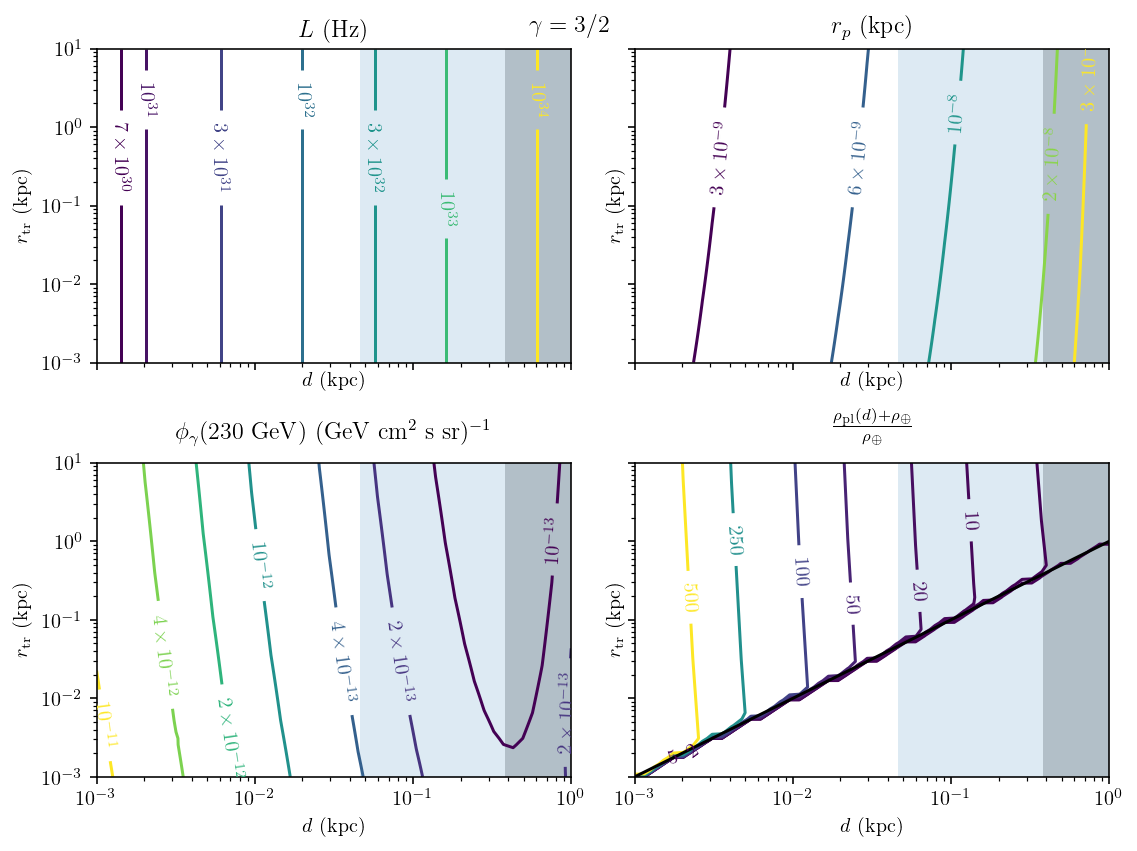

In [20]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))

for ax in axs.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(dist[[0, -1]])
    ax.set_ylim(r_tr[[0, -1]])
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_{\mathrm{tr}}$ (kpc)")
    # Line width constraint
    ax.contourf(dist_mg, r_tr_mg, lw_pt, levels=[n_sigma, np.max(lw_pt)],
                colors='k', alpha=0.2)
    # Anisotropy constraint
    ax.contourf(dist_mg, r_tr_mg, anisos_pt,
                levels=[aniso_fermi[-1], np.max(anisos_pt)],
                colors=colors[0], alpha=0.15)

ax = axs[0, 0]
ax.set_title(r"$L$ (Hz)")
sci_contours(dist_mg, r_tr_mg, lum_pt, ax, levels=levels_pl[gamma_pl]["lum"])

ax = axs[0, 1]
ax.set_title(r"$r_p$ (kpc)")
sci_contours(dist_mg, r_tr_mg, r_p, ax, levels=levels_pl[gamma_pl]["r_p"])

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
# sci_contours(dist_mg, r_tr_mg, phi_g_plateau, ax,
#              levels=log_levels(phi_g_plateau))
sci_contours(dist_mg, r_tr_mg, phi_g_pl, ax, levels=levels_pl[gamma_pl]["phi_g"])

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{pl}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
if gamma_pl == 9/4.:
    normal_contours(dist_mg, r_tr_mg, rho_rel_pl, ax,
                    levels=levels_pl[gamma_pl]["rho_rel"])
elif gamma_pl == 3/2.:
    normal_contours(dist_mg, r_tr_mg, rho_rel_pl, ax,
                    levels=levels_pl[gamma_pl]["rho_rel"], norm=None)
ax.plot(dist, dist, color='k')

if gamma_pl == 3/2.:
    fig.suptitle(r"$\gamma=3/2$")
    fig.tight_layout()
    fig.savefig("figures/contour_plots_pl_3_2.pdf")
elif gamma_pl == 9/4.:
    fig.suptitle(r"$\gamma=9/4$")
    fig.tight_layout()
    fig.savefig("figures/contour_plots_pl_9_4.pdf")